##1. Introduction & Motivation

###1.1 Introduction

<div style="line-height:1.5; text-align:justify;">

With the rapid development of social media platforms, short texts represented by Twitter have become an important medium for users to express their emotions. Parsing multimedia user data to extract meaningful information has emerged as an inevitable trend. However, characteristics inherent to user-generated content — such as linguistic simplicity, semantic implicitness, and non-standardized expressions — present significant challenges for information extraction tasks.

Taking sentiment analysis as a case study, this research constructs a comprehensive multi-model comparative framework to systematically explore the performance of deep learning methods in classifying multiple emotions expressed in tweets. The study focuses on a comparative analysis of baseline models based on recurrent neural networks (RNNs), LSTM networks, LSTM+CNN hybrid models, and heterogeneous fusion strategies involving pre-trained language models (BERT) and Transformers. The overarching goal is to achieve accurate recognition across a six-dimensional sentiment space and to improve both classification effectiveness and domain generalization through innovations in model architecture.

At the methodological level, six controlled experimental groups were designed:

- RNN model implemented from scratch<br></br>
- BiLSTM model implemented from scratch<br></br>
- LSTM+CNN conforming model implemented from scratch<br></br>
- Domain fine-tuning of lightweight pre-trained model DistilBERT<br></br>
- Self-designed Transformer streamlined architecture (Mini-BERT)<br></br>
- Integrated learning strategy combining BERT and DistilBERT heterogeneous models<br></br>


The results of this study provide a new technical reference pathway for the sentiment analysis of short texts on social media. Furthermore, the findings carry important application value in areas such as public opinion monitoring, mental health assessment, and broader fields that require nuanced understanding of user-generated emotional expressions.

</div>


### 1.2 Motivation

<div style="line-height:1.5; text-align:justify;">

**1. Background:**

With the exponential growth of social media usage, short-text platforms like Twitter have become key outlets for users to express their emotions. However, the linguistic simplicity, semantic ambiguity, and frequent use of non-standard expressions pose serious challenges to traditional sentiment analysis systems.

**2. Technical Challenges**

Existing sentiment classification models often struggle with:
- Recognizing multiple, overlapping emotions within short noisy texts.
- Adapting to complex linguistic environments that feature slang, sarcasm, and rapidly evolving expressions.
- Generalizing effectively across different emotional spaces without overfitting to high-frequency sentiment classes.

These challenges highlight the urgent need for robust, adaptable, and fine-grained emotion recognition models tailored for real-world social media contexts.

**3. Practical Significance**

This research addresses these gaps by constructing and evaluating models that:

- Improve the recognition accuracy of multi-emotion and multi-category sentiment analysis tasks.
- Model complex language environments using real-world social platform data.
- Provide efficient tools for government agencies to monitor anti-social, terrorist, or panic-inducing sentiments.
- Offer enterprises insights into user psychological trends, enabling better service and product strategies.
- Assist individuals in psychological self-monitoring, promoting early detection of depression, anxiety, and other emotional health risks.

In summary, the project carries important social, industrial, and personal implications, contributing to broader societal well-being.

</div>


##2. Dataset Description

<div style="line-height:1.5; text-align:justify;">

The tweets used in this study were initially collected by crawling posts containing emotion-related hashtags and subsequently underwent manual filtering to ensure data quality. Each message was then annotated with a single discrete emotion label by crowd-workers through a manual labeling process. This dataset was specifically constructed to benchmark affective text classification models that move beyond basic sentiment polarity (positive/negative) and are capable of recognizing fine-grained emotional categories such as anger, joy, sadness, and surprise.

**Dataset URL:** [https://huggingface.co/datasets/dair-ai/emotion](https://huggingface.co/datasets/dair-ai/emotion)

</div>


###2.1 Loading data

In [11]:
!pip install datasets -q

In [12]:
from datasets import load_dataset

dataset = load_dataset("dair-ai/emotion") # train/validation/test
print(dataset) # inspect dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


###2.2 Label

In [ ]:
label_names = dataset['train'].features['label'].names
print("label_names：", label_names)

label_names： ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


### 2.3 Data Instances

{
  "text": "im feeling quite sad and sorry for myself but ill snap out of it soon",
  "label": 0
}

### 2.4 Data Fields

- **text:** a string feature.
- **label:** a classification label, with possible values including sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5).

### 2.5 Dataset Configurations

<div style="line-height:1.5; text-align:justify;">

The **dair-ai/emotion** dataset offers two configurations for use:

- **Split configuration**:  
  In this setting, the dataset contains a total of **20,000 examples**, which are divided into:
  - **Training set**: 16,000 samples
  - **Validation set**: 2,000 samples
  - **Test set**: 2,000 samples
  
  This configuration is designed to facilitate standardized model evaluation by providing predefined splits for training, hyperparameter tuning, and performance testing.

- **Unsplit configuration**:  
  In this version, the dataset contains **416,809 examples** consolidated into a single training split without predefined validation or test sets. This unsplit version offers a larger and more diverse sample pool, suitable for customized partitioning, pretraining tasks, or semi-supervised learning scenarios.

For the purposes of this project, the **split configuration** is adopted to ensure experimental consistency, fair benchmarking across models, and direct comparability with prior work that follows the same data division.

</div>


##3. Exploratory Data Analysis

In this section, we will perform an exploratory analysis of the dataset to understand its structure, challenges, and potential preprocessing needs.

We focus on:

- Text length distribution
- Token-level complexity
- Category imbalance
- Noise in the data (e.g. slang).

In order to accurately solve these problems, we visualized the data and analyzed the data characteristics based on the data characteristics of random samples to understand the data characteristics and finally solve them effectively.



###3.1 Class Distribution

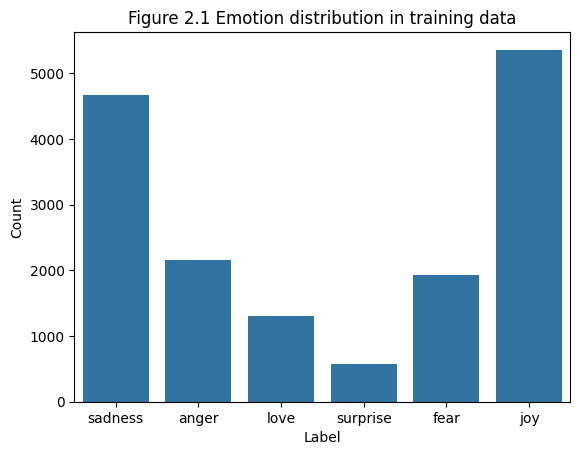

In [ ]:
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

counts = Counter(dataset['train']['label'])
label_names = dataset['train'].features['label'].names

label_df = pd.DataFrame({
    "Label": [label_names[i] for i in counts.keys()],
    "Count": list(counts.values())
})

sns.barplot(data=label_df, x="Label", y="Count")
plt.title('Figure 3.1 Emotion distribution in training data')
plt.show()

<div style="line-height:1.5; text-align:justify;">

**Impact of Class Imbalance:**


The column chart illustrating the emotion distribution in the training dataset reveals a significant imbalance across emotion labels. Specifically, the classes representing **joy** and **sadness** dominate the dataset, with approximately 5,300 and 4,700 samples respectively, accounting for the majority of the training data. In contrast, the **surprise** class contains only around 500 samples, making it the least represented emotion category.

Such an imbalanced class distribution can adversely affect model performance. During training, models are more likely to learn and reinforce the features of high-frequency classes. Consequently, during prediction, the model may tend to classify input samples disproportionately into dominant categories like joy or sadness. Meanwhile, the predictive accuracy for minority classes, such as surprise, tends to be significantly lower, leading to issues such as class bias, overfitting, and degraded overall model generalization.

**Mitigation Strategies:**

- **Class-Weighted Loss Functions**: By assigning higher loss weights to minority classes during training, the model is encouraged to pay more attention to underrepresented categories, thereby balancing the learning process.
  
- **Resampling Techniques**: Both undersampling of dominant classes and oversampling of minority classes are considered to rebalance the training dataset and reduce bias.
  
- **Data Augmentation for Minority Classes**: Techniques such as sentence paraphrasing, synonym replacement, and slight semantic alterations are applied to artificially expand the size of minority class datasets, enhancing the model’s robustness and improving its generalization ability across all categories.

</div>


###3.2. Original Sample Example

<div style="line-height:1.5; text-align:justify;">

**Challenges Beyond Class Imbalance: Language Complexity and Semantic Ambiguity:**


In addition to the problem of imbalanced category distribution, the emotion classification task also faces substantial challenges related to language complexity and semantic ambiguity. To better understand the difficulties encountered by models under real-world corpus conditions, several original tweet samples from the training set were examined and printed for observation.

As shown in 2.2 Label, five labeled tweet samples illustrate the diversity of emotional expression. Emotions are often conveyed through short, colloquial texts that frequently lack clear contextual cues. For example, the tweet "i go from feeling so hopeless to so damned hopeful" demonstrates an emotional transition process, indicating that keyword-based methods alone are insufficient for accurate classification. Proper interpretation requires inferring emotional shifts from contextual information. Similarly, the sentence "i am ever feeling nostalgic about the fireplace" conveys a mixture of love, nostalgia, and emotional attachment, further emphasizing the necessity of deep contextual understanding rather than surface-level semantic parsing.

Moreover, there are clear semantic overlaps and blurred boundaries between different emotion categories. Texts expressing "anger" may stylistically resemble those expressing "fear" or "sadness," complicating the task of precise classification. These subtle distinctions make it challenging for models that rely purely on shallow lexical features or singular architecture designs to perform reliably.

In summary, the dual challenges of class imbalance and semantic ambiguity highlight the necessity of deploying context-sensitive deep language models, such as Transformer-based architectures like BERT. These models are better equipped to capture complex emotional nuances and improve classification performance on noisy, real-world textual data.

</div>


In [ ]:
for i in range(5):
    text = dataset["train"][i]["text"]
    label = label_names[dataset["train"][i]["label"]]
    print(f"[{label.upper()}] {text}")

[SADNESS] i didnt feel humiliated
[SADNESS] i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
[ANGER] im grabbing a minute to post i feel greedy wrong
[LOVE] i am ever feeling nostalgic about the fireplace i will know that it is still on the property
[ANGER] i am feeling grouchy


### 3.3 Max_length analysis

<div style="line-height:1.5; text-align:justify;">

**Text Length Distribution Analysis:**

To further understand the structural characteristics of the original text data, a statistical analysis was conducted on the word counts of all tweets in the training set. As shown in the corresponding figure, the distribution of tweet lengths exhibits a right-skewed long-tail pattern, meaning that most tweets are relatively short while a minority of tweets are significantly longer.

Overall, the average tweet length in the training set is approximately **19.17 words**, with the longest tweet reaching **66 words**. According to the plotted distribution, more than **80%** of the tweets fall within the **5 to 30 words** range, which aligns with Twitter's design philosophy of encouraging concise and direct expression.

Considering the predominance of short texts, to balance between minimizing information truncation and avoiding unnecessary memory waste during training, the maximum sequence length (**max_length**) for subsequent model construction was set to **128 tokens**. This setting sufficiently covers the full content of most samples while reducing the risk of information loss from excessive truncation.

Furthermore, the right-skewed nature of the text length distribution also highlights the importance of considering text length diversity during data augmentation or adversarial sample generation. Ensuring that synthetic data reflects the real-world variation in text lengths is crucial for enhancing the model's robustness and generalization across different input scenarios.

</div>


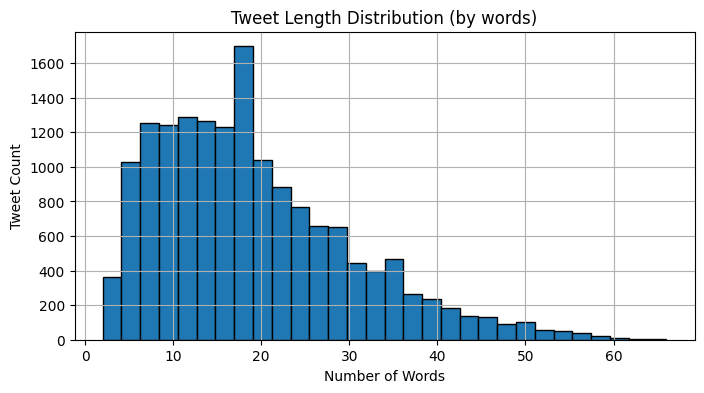

average length: 19.17 words
maximum length: 66 words


In [13]:
import matplotlib.pyplot as plt

train_texts = dataset["train"]["text"]
text_lengths = [len(text.split()) for text in train_texts]

plt.figure(figsize=(8, 4))
plt.hist(text_lengths, bins=30, color="#1f77b4", edgecolor="black")
plt.title("Tweet Length Distribution (by words)")
plt.xlabel("Number of Words")
plt.ylabel("Tweet Count")
plt.grid(True)
plt.show()

print(f"average length: {sum(text_lengths) / len(text_lengths):.2f} words")
print(f"maximum length: {max(text_lengths)} words")

### 3.4 Content feature analysis

From sample tweets, we observe:

- Frequent use of informal language (slang, abbreviations)
- Short sentence fragments
Such patterns may affect tokenization and model robustness. Therefore, our preprocessing should aim to:

- Lowercase text
- Remove links, mentions, and excess punctuation
Observe the language noise and non-standard usage in the data.

By extracting several real tweets, we can see that the tweets contain:

Informal expressions (such as "i m" for "I'm"), non-standard spelling, omitted punctuation, mixed long and short sentences, and possible inclusion of Internet language, etc. These all pose challenges to the tokenizer performance and context understanding ability of the NLP model.

By randomly extracting some training samples, we further observed several characteristics of the original tweets in actual language use, including informal expressions (such as abbreviations, omissions), special symbols, and fragmented sentence structure. Although these phenomena have the natural attributes of social language, they may interfere with word segmentation, semantic modeling, and classification judgment at the model input stage, especially for context-sensitive models.

Therefore, in view of these characteristics, we uniformly convert them to lowercase letters in the preprocessing stage to reduce the impact of word form variation on word vectors, and remove noise information such as meaningless links, @ mentions, and redundant punctuation. Try to improve the standardization of model input while retaining semantic information, thereby improving the overall sentiment classification effect and model robustness.

In [ ]:
import random

for i in random.sample(range(len(train_texts)), 5):
    text = dataset["train"][i]["text"]
    label = label_names[dataset["train"][i]["label"]]
    print(f"[{label.upper()}] {text}\n")

[SADNESS] i do find new friends i m going to try extra hard to make them stay and if i decide that i don t want to feel hurt again and just ride out the last year of school on my own i m going to have to try extra hard not to care what people think of me being a loner

[JOY] i asked them to join me in creating a world where all year old girls could grow up feeling hopeful and powerful

[LOVE] i feel when you are a caring person you attract other caring people into your life

[FEAR] i sometimes feel so vulnerable and so lost

[SADNESS] i think you would all agree that feeling your toes and fingers go numb is perhaps one of the most unpleasant feelings ever



In [ ]:
# Data Cleaning
import re

def clean_tweet(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    return text

sample_text = dataset["train"][0]["text"]
print("Before:", sample_text)
print("After :", clean_tweet(sample_text))

Before: i didnt feel humiliated
After : i didnt feel humiliated


##4. Models and Methods

<div style="line-height:1.5; text-align:justify;">
This project aims to systematically evaluate the performance of six text sentiment classification models in the task of sentiment recognition in English tweets (Tweets). The selected models range from classic neural networks to modern pre-trained models, including:

- RNN model implemented from scratch:  
RNN can capture temporal dependencies in text and is suitable for processing local structures in natural language. However, its ability to model long-distance dependencies is limited, and there may be learning bottlenecks in dealing with semantic ambiguity and category imbalance, especially in unstructured texts such as tweets.

- BiLSTM model implemented from scratch:  
The Bidirectional LSTM (BiLSTM) extends the standard LSTM by introducing a second layer that processes the input sequence in reverse order, allowing the model to capture information from both past and future contexts. This structure is particularly beneficial for sentiment classification tasks, where emotional meaning often depends on both preceding and following words. By simultaneously modeling forward and backward dependencies, BiLSTM provides more comprehensive contextual representations compared to unidirectional LSTM, enhancing the model's ability to distinguish subtle emotional expressions in short and informal texts like tweets.

- LSTM + CNN composite model implemented from scratch:  
This model combines the temporal modeling capabilities of LSTM with the efficient extraction capabilities of CNN for local n-gram patterns, which helps capture the phrase features and contextual semantics in tweets, especially for capturing emotional keywords. This structure can improve the robustness of expression details while retaining the contextual modeling capabilities.

- DistilBERT model fine-tuned by HuggingFace:  
DistilBERT is a distilled version of BERT, which retains most of the semantic modeling capabilities of the original model, but is smaller and faster to reason about. Its Transformer architecture has the advantage of global context modeling, and can provide excellent performance in complex semantic and long-distance dependency scenarios, especially suitable for social media texts with rich semantic expressions but loose structures.

- Customized Mini-BERT Transformer model:  
This model is simplified with reference to the BERT architecture, aiming to retain the core advantages of Transformer under the condition of limited computing resources. Its self-attention mechanism enables the model to dynamically focus on semantic key positions, with good interpretability and language generalization capabilities, especially in emotion recognition tasks with blurred inter-class boundaries.

- Soft Voting ensemble model based on BERT and DistilBERT:  
This model combines the output results of BERT and DistilBERT through a soft voting mechanism to balance accuracy and computational efficiency. The ensemble strategy is expected to improve the stability of the model and its robustness to low-frequency categories, and is particularly suitable for practical application scenarios where unbalanced data distribution and semantic uncertainty coexist.

To ensure the consistency of the evaluation of each model, the experiment uniformly uses the public dataset [dair-ai/emotion], which contains 20,000 English tweets with the following emotion categories: sadness, joy, love, anger, fear, surprise. We divide it into a training set (16,000), a validation set (2,000), and a test set (2,000) in a ratio of 8:1:1.
</div>


###4.1 RNN Model from Scratch

<div style="line-height:1.5; text-align:justify;">

The Recurrent Neural Network (RNN) is one of the foundational architectures for sequence modeling tasks in natural language processing. Unlike traditional feedforward neural networks, RNNs are specifically designed to handle sequential data by introducing recurrent connections between hidden units. This allows information from previous time steps to be carried forward, enabling the network to maintain a form of memory about prior inputs when making current predictions.

In the context of text sentiment classification, RNNs process input sequences word by word, updating their hidden state at each step based on both the current input and the previous hidden state. This sequential processing makes RNNs naturally suitable for capturing local temporal dependencies within text, such as phrase-level sentiment patterns.

However, traditional RNNs are known to suffer from limitations when modeling long-distance dependencies due to issues such as the vanishing gradient problem. As the sequence length increases, the network’s ability to retain and effectively utilize information from earlier tokens diminishes, leading to challenges in accurately capturing the global context necessary for nuanced sentiment understanding, particularly in cases where emotional cues are distributed across the sentence.

Despite these limitations, RNNs offer computational simplicity and form a valuable baseline for sentiment classification tasks. In this project, an RNN model is implemented from scratch to serve as a comparative reference point for evaluating the effectiveness of more advanced architectures, such as LSTM, CNN-LSTM hybrids, and Transformer-based models.

</div>


In [ ]:
!pip install -q transformers datasets seaborn

In [ ]:

from datasets import load_dataset
import pandas as pd

dataset = load_dataset("dair-ai/emotion")

train_df = dataset["train"].to_pandas()
validation_df = dataset["validation"].to_pandas()
test_df = dataset["test"].to_pandas()


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
import pandas as pd
import os
import torch
import random
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer
import os
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.style.use('ggplot')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
def seed_all(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_all(seed=2025)


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer
import numpy as np

class DataHandler:
    def __init__(self, is_verbose=True, seed=6789):
        self.is_verbose = is_verbose
        self.max_length = None
        self.seed = seed
        self.random_generator = np.random.RandomState(seed)
        self.num_classes = 6
        self.max_sequence_length = 85

    def load_data(self, dataframe):
        text_list = dataframe['text'].values
        label_list = dataframe['label'].values

        if self.is_verbose:
            print("\nSample text and corresponding labels... \n")
            print(pd.DataFrame({'text':text_list[0:5],
                                "label":label_list[0:5]}))
        return text_list, label_list

    def process_texts(self, text_list):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        vocabulary = self.tokenizer.get_vocab()
        self.word_to_index = {word: index for index, word in enumerate(vocabulary)}
        self.index_to_word = {index: word for word, index in self.word_to_index.items()}
        self.vocabulary_size = len(self.word_to_index)

        numerical_sequences = []
        for text in text_list:
            text_tokens = self.tokenizer.tokenize(str(text))
            token_ids = self.tokenizer.convert_tokens_to_ids(text_tokens)
            sequence_tensor = torch.LongTensor(token_ids)
            numerical_sequences.append(sequence_tensor)

        if numerical_sequences:
            padded_data = pad_sequence(numerical_sequences, batch_first=True)
            self.num_sentences, _ = padded_data.shape
            return padded_data

    def split_data_loaders(self, batch_size=64):
        train_texts, train_labels = self.load_data(train_df)
        train_texts = self.process_texts(train_texts)
        train_labels = torch.from_numpy(train_labels)
        train_dataset = TensorDataset(train_texts, train_labels)

        test_texts, test_labels = self.load_data(test_df)
        test_texts = self.process_texts(test_texts)
        test_labels = torch.from_numpy(test_labels)
        test_dataset = TensorDataset(test_texts, test_labels)

        valid_texts, valid_labels = self.load_data(validation_df)
        valid_texts = self.process_texts(valid_texts)
        valid_labels = torch.from_numpy(valid_labels)
        valid_dataset = TensorDataset(valid_texts, valid_labels)

        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        self.valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
dh = DataHandler()
dh.split_data_loaders()


Sample text and corresponding labels... 

                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


Sample text and corresponding labels... 

                                                text  label
0  im feeling rather rotten so im not very ambiti...      0
1          im updating my blog because i feel shitty      0
2  i never make her separate from me because i do...      0
3  i left with my bouquet of red and yellow tulip...      1
4    i was feeling a little vain when i did this one      0

Sample text and corresponding labels... 

                                                text  label
0  im feeling quite sad and sorry for myself but ...      0
1  i feel like i am still looking at a blank canv...      0
2                     i feel like a faithful servant      2
3                  i am just feeling cranky and blue      3
4  i can have for a treat or if i am feeling festive      1


In [ ]:
import torch

class ModelTrainer:
    def __init__(self, model, loss_function, optimizer,
                 training_loader, validation_loader):
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.training_loader = training_loader
        self.validation_loader = validation_loader

    def train_model(self, num_epochs):
        num_batches = len(self.training_loader)

        history = {
            'train_loss': [],
            'train_accuracy': [],
            'val_loss': [],
            'val_accuracy': []
        }

        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            train_loss, train_accuracy = self.train_single_epoch()
            val_loss, val_accuracy = self.validate_single_epoch()

            history['train_loss'].append(train_loss)
            history['train_accuracy'].append(train_accuracy)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_accuracy)

            print(
                f'- train_loss: {train_loss:.4f}\t'
                f'- train_accuracy: {train_accuracy * 100:.4f}%\t'
                f'- val_loss: {val_loss:.4f}\t'
                f'- val_accuracy: {val_accuracy * 100:.4f}%'
            )

        return history

    def train_single_epoch(self):
        self.model.train()
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        num_batches = len(self.training_loader)

        for i, data in enumerate(self.training_loader):
            inputs, labels = data
            device = next(self.model.parameters()).device
            inputs, labels = inputs.to(device), labels.to(device)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.loss_function(outputs, labels)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        train_accuracy = correct_predictions / total_samples
        train_loss = total_loss / num_batches
        return train_loss, train_accuracy

    def evaluate_model(self, data_loader):
        self.model.eval()
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for data in data_loader:
                inputs, labels = data
                device = next(self.model.parameters()).device
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.model(inputs)
                loss = self.loss_function(outputs, labels)
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        accuracy = correct_predictions / total_samples
        loss = total_loss / len(data_loader)
        return loss, accuracy

    def validate_single_epoch(self):
        val_loss, val_accuracy = self.evaluate_model(self.validation_loader)
        return val_loss, val_accuracy

In [ ]:
import torch
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, embedding_size=128, hidden_state_sizes=[128, 128],
                 data_handler=None):
        super().__init__()
        self.hidden_state_sizes = hidden_state_sizes
        self.embedding_size = embedding_size
        self.data_handler = data_handler
        self.vocabulary_size = self.data_handler.vocabulary_size

    @staticmethod
    def get_recurrent_layer(input_size=128, hidden_size=128):
        return nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)

    def construct_model(self):
        self.model_layers = nn.ModuleList()
        self.model_layers.append(nn.Embedding(self.vocabulary_size, self.embedding_size))
        current_input_size = self.embedding_size
        for hidden_size in self.hidden_state_sizes:
            self.model_layers.append(self.get_recurrent_layer(current_input_size, hidden_size))
            current_input_size = hidden_size
        self.final_linear_layer = nn.Linear(self.hidden_state_sizes[-1], self.data_handler.num_classes)
        return self

    def forward(self, input_sequence):
        embedded_sequence = self.model_layers[0](input_sequence)
        for rnn_layer in self.model_layers[1:]:
            output_sequence, _ = rnn_layer(embedded_sequence)
            embedded_sequence = output_sequence
        averaged_output = torch.mean(output_sequence, dim=1)
        return self.final_linear_layer(averaged_output)

In [ ]:

rnn_model = RNNModel(embedding_size=128,
                     hidden_state_sizes=[128, 128],
                     data_handler=dh)
rnn = rnn_model.construct_model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)
print(rnn)

RNNModel(
  (model_layers): ModuleList(
    (0): Embedding(30522, 128)
    (1-2): 2 x RNN(128, 128, batch_first=True)
  )
  (final_linear_layer): Linear(in_features=128, out_features=6, bias=True)
)


In [ ]:
trainer = ModelTrainer(model= rnn, loss_function=criterion,
                      optimizer=optimizer,
                      training_loader=dh.train_loader,
                      validation_loader=dh.valid_loader)
history = trainer.train_model(num_epochs=20)

Epoch 1/20
- train_loss: 1.5724	- train_accuracy: 34.3813%	- val_loss: 1.5324	- val_accuracy: 39.8500%
Epoch 2/20
- train_loss: 1.5195	- train_accuracy: 41.0438%	- val_loss: 1.4920	- val_accuracy: 45.2000%
Epoch 3/20
- train_loss: 1.3814	- train_accuracy: 49.2250%	- val_loss: 1.4178	- val_accuracy: 47.8500%
Epoch 4/20
- train_loss: 1.2449	- train_accuracy: 55.2188%	- val_loss: 1.2134	- val_accuracy: 57.4500%
Epoch 5/20
- train_loss: 1.0750	- train_accuracy: 62.5250%	- val_loss: 1.0966	- val_accuracy: 63.0000%
Epoch 6/20
- train_loss: 0.9238	- train_accuracy: 67.6625%	- val_loss: 1.0389	- val_accuracy: 64.5000%
Epoch 7/20
- train_loss: 0.7923	- train_accuracy: 72.2125%	- val_loss: 0.9443	- val_accuracy: 70.5000%
Epoch 8/20
- train_loss: 0.8511	- train_accuracy: 69.0562%	- val_loss: 1.7478	- val_accuracy: 56.8500%
Epoch 9/20
- train_loss: 0.8451	- train_accuracy: 70.6812%	- val_loss: 1.1272	- val_accuracy: 65.5000%
Epoch 10/20
- train_loss: 0.6644	- train_accuracy: 77.1375%	- val_loss: 1

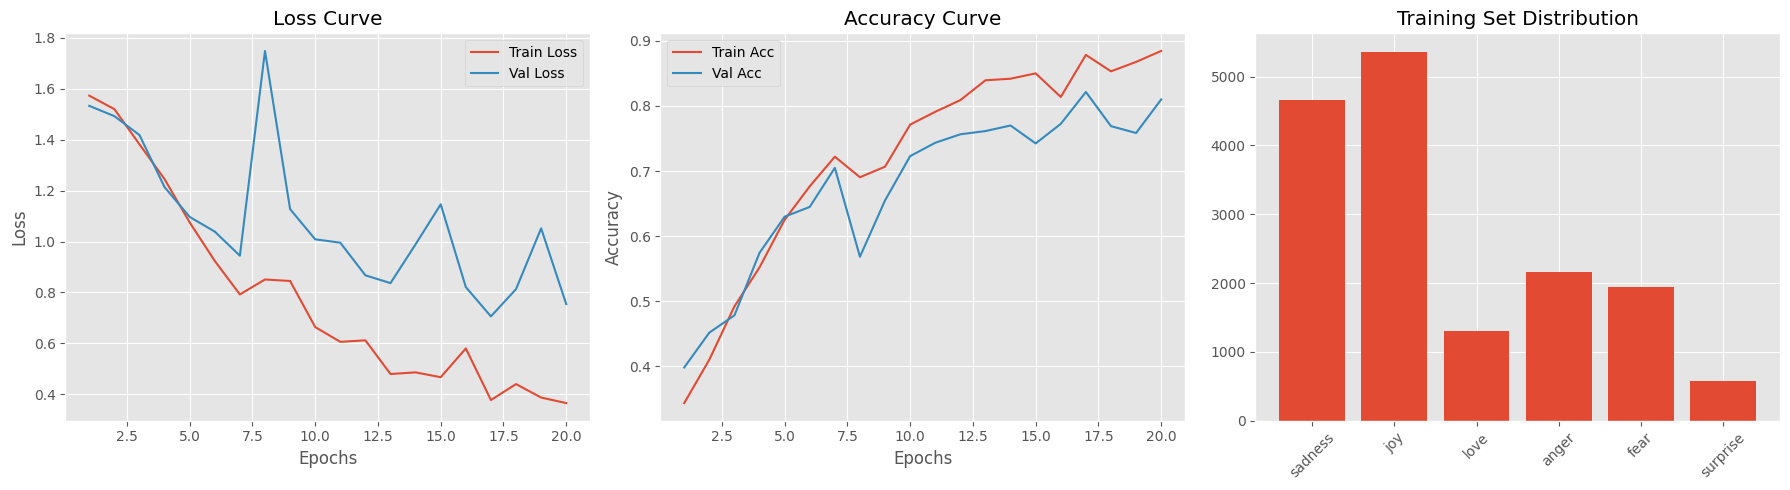

In [ ]:
from datasets import load_dataset

dataset = load_dataset("dair-ai/emotion")
train_df = dataset["train"].to_pandas()
label_names = dataset["train"].features["label"].names

import matplotlib.pyplot as plt

def plot_all(history, label_names, train_df):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_accuracy'], label='Train Acc')
    plt.plot(epochs, history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.subplot(1, 3, 3)
    value_counts = train_df['label'].value_counts().sort_index()
    plt.bar(label_names, value_counts)
    plt.title('Training Set Distribution')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

plot_all(history, label_names, train_df)

<div style="line-height:1.5; text-align:justify;">

These chart illustrates the training and validation loss curves as well as the corresponding accuracy curves over the course of 20 epochs. These curves provide insights into the learning dynamics and generalization behavior of the model during training.

From the **loss curve**, it can be observed that both the training loss and validation loss decrease steadily in the early stages of training, indicating effective convergence. However, fluctuations in the validation loss begin to emerge after approximately the seventh epoch. While the training loss continues to decline consistently, the instability of the validation loss suggests that the model may be starting to overfit to the training data, particularly in the later stages of training.

The **accuracy curve** shows that both training and validation accuracies increase throughout the training process. Training accuracy rises more rapidly and surpasses validation accuracy after the midpoint of training. Although the final validation accuracy remains reasonably high (around 80%), the growing gap between training and validation performance reflects a typical overfitting trend, which warrants careful monitoring and potentially the use of additional regularization techniques, such as dropout or early stopping.

Overall, the training process demonstrates good initial learning behavior, but also highlights the importance of balancing model capacity and generalization to maintain robust performance on unseen data.

</div>



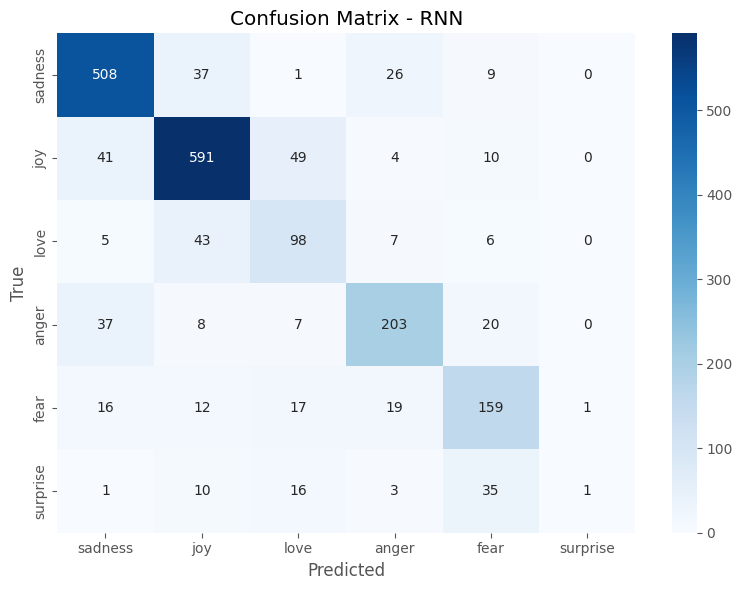

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)

y_pred, y_true = get_predictions(rnn, dh.test_loader)

def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix - RNN"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

label_names = dataset["train"].features["label"].names
plot_confusion_matrix(y_true, y_pred, label_names, title="Confusion Matrix - RNN")

<div style="line-height:1.5; text-align:justify;">

The chart presents the confusion matrix for the RNN model evaluated on the test set. The confusion matrix offers a detailed view of the model's prediction behavior across the six emotion categories.

The diagonal entries, representing correct predictions, show that the model achieves relatively high classification accuracy for **joy** (591 correct predictions) and **sadness** (508 correct predictions), which aligns with the higher sample frequencies of these two categories in the training set. This outcome also reflects the RNN's better performance on majority classes.

However, the model exhibits notable misclassification tendencies, particularly between semantically similar emotions. For instance, samples from the **love** category are often misclassified as **joy** (43 instances) and vice versa (49 instances), highlighting the model's difficulty in distinguishing nuanced emotional expressions. Similarly, a proportion of **fear** and **anger** instances are confused with each other, which is consistent with the semantic proximity between these emotions.

The minority categories, such as **surprise**, suffer from relatively poor prediction performance, with significant confusion with emotions like **fear** and **love**. Only a small number of **surprise** instances are correctly classified, which reflects the challenges posed by data imbalance and the limited representational capacity of the RNN when handling rare classes.

Overall, the confusion matrix highlights that while the RNN model is capable of recognizing dominant emotional trends, it struggles with fine-grained sentiment distinctions and minority class detection. These observations reinforce the need for more powerful sequence models and class balancing techniques in future work.

</div>


In [ ]:
test_loss, test_acc = trainer.evaluate_model(dh.test_loader)
print(f'test_loss: {test_loss:.4f} - test_accuracy: {test_acc*100:.4f}%')
save_path = 'rnn.pth'
torch.save(trainer.model.state_dict(), save_path)

test_loss: 0.7610 - test_accuracy: 78.0000%


In [ ]:
import torch
from sklearn.metrics import f1_score, precision_score, recall_score

def evaluate_model(model, num_test_batches, device, data_module):
    model.eval()
    total_samples = 0
    correct_predictions = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in data_module.test_loader:
            features, targets = batch
            features = features.to(device)
            targets = targets.to(device)
            outputs = model(features)
            _, predictions = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            correct_predictions += (predictions == targets).sum().item()
            all_predictions.extend(predictions.cpu().tolist())
            all_targets.extend(targets.cpu().tolist())
            num_test_batches -= 1
            if num_test_batches == 0:
                break

        accuracy = correct_predictions / total_samples
        f1 = f1_score(all_targets, all_predictions, average='weighted')
        precision = precision_score(all_targets, all_predictions, average='weighted')
        recall = recall_score(all_targets, all_predictions, average='weighted')

        print(f"{total_samples} Test Samples Accuracy: {accuracy}")
        print(f"F1 Score: {f1}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")

    return all_predictions, all_targets

In [ ]:
test_count = 1
model_predict, labels = evaluate_model(model=rnn,
                                       num_test_batches=test_count,
                                       device=device,
                                       data_module=dh)


64 Test Samples Accuracy: 0.8125
F1 Score: 0.8135734914120686
Precision: 0.8185369318181819
Recall: 0.8125


In [ ]:
import pandas as pd


label_to_text = {
    0: "sadness",
    1: "joy",
    2: "fear",
    3: "anger",
    4: "surprise",
    5: "trust",
    6: "disgust",
    7: "anticipation"
}


results = pd.DataFrame({
    'text': test_df['text'][:test_count * 64].values,
    'true_label': test_df['label'][:test_count * 64].values,
    'predicted_label': model_predict
})


results['true_label_text'] = results['true_label'].apply(lambda x: label_to_text[x])
results['predicted_label_text'] = results['predicted_label'].apply(lambda x: label_to_text[x])

results

,text,true_label,predicted_label,true_label_text,predicted_label_text
0,im feeling rather rotten so im not very ambiti...,0,0,sadness,sadness
1,im updating my blog because i feel shitty,0,0,sadness,sadness
2,i never make her separate from me because i do...,0,0,sadness,sadness
3,i left with my bouquet of red and yellow tulip...,1,1,joy,joy
4,i was feeling a little vain when i did this one,0,0,sadness,sadness
...,...,...,...,...,...
59,i think about the things ive said and the stuf...,3,3,anger,anger
60,i woke up yesterday monday morning feeling a l...,0,0,sadness,sadness
61,i feel so embarrassed,0,0,sadness,sadness
62,i spent wandering around still kinda dazed and...,1,4,joy,surprise


<div style="line-height:1.5; text-align:justify;">

**Case Study of RNN Model Predictions:**

To gain deeper insight into the RNN model's performance beyond aggregated metrics, a case-by-case analysis was conducted on a subset of test samples. Each entry records the original tweet text, the true emotion label, and the model's predicted label.

Observations indicate that the model correctly identifies the sentiment for the majority of straightforward emotional expressions. For instance, tweets explicitly conveying sadness or frustration, such as *"I'm feeling rather rotten so I'm not very ambitious right now"* and *"I'm updating my blog because I feel shitty,"* are accurately classified as **sadness**. Similarly, positive expressions like *"I left with my bouquet of red and yellow tulips"* are correctly recognized as **joy**.

However, misclassifications still occur, especially in cases involving subtle or ambiguous emotional cues. For example, the tweet *"I spent wandering around still kinda dazed and surprised"* was originally labeled as **joy**, but was predicted as **surprise** by the model. This type of confusion highlights the model’s difficulty in interpreting nuanced emotional shifts and the overlap between certain emotional categories.

Such errors reflect broader challenges identified earlier, including the need for stronger contextual modeling and better handling of semantic ambiguity. They also underline the limitations of the RNN's capacity to differentiate between closely related emotional states based purely on surface-level text features.

In summary, while the RNN model demonstrates a reasonable ability to classify clear-cut emotions, its performance diminishes when handling nuanced, multi-layered emotional expressions. Future improvements could involve deploying models with enhanced contextual sensitivity or applying data augmentation techniques to expose the model to a wider variety of linguistic patterns during training.

</div>


In [ ]:
results[results['true_label_text']!=results['predicted_label_text']]


,text,true_label,predicted_label,true_label_text,predicted_label_text
10,i don t feel particularly agitated,4,3,surprise,anger
12,i pay attention it deepens into a feeling of b...,4,0,surprise,sadness
17,i feel like my only role now would be to tear ...,0,1,sadness,joy
18,i feel just bcoz a fight we get mad to each ot...,3,1,anger,joy
29,i highly recommend visiting on a wednesday if ...,3,1,anger,joy
36,i feel very honoured to be included in a magzi...,1,2,joy,fear
49,i was feeling pretty anxious all day but my fi...,4,1,surprise,joy
50,i stood up to you i finally stood up to you an...,0,4,sadness,surprise
52,i feel like i could go into any situation and ...,1,0,joy,sadness
53,i can t stop the anxiety i feel when i m alone...,0,1,sadness,joy


**Case Study of Misclassifications:**

<div style="line-height:1.5; text-align:justify;">

To better understand the types of errors made by the RNN model, a focused case study was conducted on misclassified test samples. Analysis reveals that misclassifications often occur between semantically adjacent emotions, or when the emotional expression in the tweet is subtle or contextually complex. Notably, emotions such as **surprise**, **anger**, and **joy** exhibit considerable overlap in mispredictions.

The chart above presents selected examples of misclassified tweets, illustrating typical confusion patterns encountered by the model.

These cases highlight the RNN model's difficulty in distinguishing nuanced emotional states, especially when tweets involve multiple or evolving sentiments. This reinforces the need for stronger contextual modeling and suggests opportunities for future improvements using more advanced architectures.

</div>


###4.2 LSTM + CNN

#### Emotion Classification with Neural Networks

##### 1. Introduction
In this project, we aim to classify text samples into one of seven emotion categories using a deep learning approach. Understanding emotions in text is crucial for applications in sentiment analysis, human-computer interaction, and mental health support.

##### 2. Dataset and Emotion Labels
We use the `dair-ai/emotion` dataset from HuggingFace, which contains annotated tweets classified into the following emotions:
- Anger, Fear, Joy, Sadness, Surprise, Trust

##### 3. Exploratory Data Analysis

anger: Approximately 5,000 samples

fear: Approximately 4,000 samples

joy (Happiness) : Approximately 3,000 samples

sadness: Approximately 2,000 samples

surprise: Approximately 1,000 samples

trust: The sample size is close to 0.


##### 4.challenges
The data is highly unbalanced, and most of the samples are concentrated in the two categories of anger and fear.

The trust category is seriously lacking and basically cannot be used for supervised learning.

Extreme imbalance will affect the performance of the model, especially causing recognition difficulties for a few classes.

##### 5.applied
The model design inspiration of this project comes from the following classic literature:
>- LSTM structure reference: Hochreiter & Schmidhuber (1997)
> - CNN Applied to Text Classification Reference Kim (2014)
> - LSTM-CNN combined structure Reference: Zhou et al. (2015)
> - Tokenizer: A pre-trained tokenizer using the BERT model. Devlin et al. (2019)
> - The emotion classification dataset cites Saravia et al. (2018)

（References）
Hochreiter, S., & Schmidhuber, J. (1997).
Long short-term memory. Neural Computation, 9(8), 1735–1780.
https://doi.org/10.1162/neco.1997.9.8.1735

Kim, Y. (2014).
Convolutional Neural Networks for Sentence Classification. In Proceedings of EMNLP 2014.
https://arxiv.org/abs/1408.5882

Zhou, C., Sun, C., Liu, Z., & Lau, F. (2015).
A C-LSTM Neural Network for Text Classification.
https://arxiv.org/abs/1511.08630

Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2019).
BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. In Proceedings of NAACL 2019.
https://arxiv.org/abs/1810.04805

Saravia, E., Liu, H., Huang, Y., Wu, J., & Cambria, E. (2018).
CARER: Contextualized Affect Representations for Emotion Recognition. In Proceedings of EMNLP 2018.
https://aclanthology.org/D18-1404/
(Dataset available via HuggingFace: dair-ai/emotion)


##### 6. Model Architecture
We use a hybrid LSTM+CNN model. The LSTM captures sequential dependencies while the CNN captures local patterns.

##### 7. Training
We train for 20 epochs using Adam optimizer and cross-entropy loss.

##### 8. Results and Evaluation
We evaluate on the validation and test sets, reporting accuracy and loss curves, and a confusion matrix.
LSTM+CNN model yielded the best of the three (0.9458) though its macro F1-score was below it (0.75, because it performed significantly worse on the dominating classes). Training and validation loss fell precipitously and followed each other closely, showing very stable training and very little overfitting.
This model accurately detected anger (563 examples) and fear (639 examples), achieved decent results on joy and sadness, and misclassified under-sampled classes (i.e. trust) that were more confused with fear and surprise.

##### 9. Discussion
- Strengths: Combines temporal and spatial understanding.
- Limitations: Fixed sequence length, may not capture long-term context deeply.
- Future Work: Try pretrained embeddings or transformer-based models.
Below is the label mapping used in the project:

```python
LABEL_MAP = {
    'anger': 0,
    'fear': 1,
    'joy': 2,
    'sadness': 3,
    'surprise': 4,
    'trust': 5,
}
ID_TO_LABEL = {v: k for k, v in LABEL_MAP.items()}
NUM_CLASSES = len(LABEL_MAP)



<div style="line-height:1.5; text-align:justify;">

The LSTM+CNN composite model integrates the strengths of Long Short-Term Memory (LSTM) networks and Convolutional Neural Networks (CNN) to enhance sequence modeling performance in text classification tasks. This hybrid architecture is designed to leverage LSTM's ability to capture long-term dependencies in sequential data and CNN's capacity for extracting local feature patterns, such as n-gram phrases.

In the LSTM+CNN structure, the input text is first processed by LSTM layers, which encode sequential contextual information and generate hidden state representations at each time step. These hidden states are then passed through convolutional layers, where local sliding windows operate on sequences of hidden states to extract salient sub-sequence features. Pooling operations may be applied afterward to distill the most informative signals from the convolution outputs.

This combination allows the model to benefit from both temporal and spatial feature extraction: LSTM ensures that long-range dependencies and contextual sentiment shifts are retained, while CNN efficiently captures short-term local patterns such as emotional keywords or key phrases. This dual-perspective modeling is particularly advantageous for texts like tweets, where emotional expressions often emerge through a mixture of local cues and overall context.

In this project, the LSTM+CNN model is implemented from scratch to serve as a comparative baseline against pure sequential models, such as RNN and LSTM model, and against more advanced Transformer-based architectures. It is expected that the hybrid model will demonstrate improved robustness in capturing diverse semantic signals and offer enhanced performance in emotion classification tasks compared to standalone RNN or LSTM structures.

</div>


In [ ]:
!pip install -q transformers datasets huggingface_hub pyarrow torch pandas numpy

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from huggingface_hub.file_download import logger as hf_logger
from datasets import load_dataset

hf_logger.setLevel("ERROR")
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# label mapping
LABEL_MAP = {
    'anger': 0,
    'fear': 1,
    'joy': 2,
    'sadness': 3,
    'surprise': 4,
    'trust': 5,
}
ID_TO_LABEL = {v: k for k, v in LABEL_MAP.items()}
NUM_CLASSES = len(LABEL_MAP)

# Model hyperparameters
MAX_LEN = 128
BATCH_SIZE = 32
EMBED_DIM = 256
HIDDEN_DIM = 128
N_LAYERS = 1
DROPOUT = 0.5
LR = 1e-3
EPOCHS = 20
NUM_FILTERS = 100
FILTER_SIZES = [3, 4, 5]  # Convolution kernel size
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==================== data loading ====================
def load_data(split):
    from datasets import load_dataset
    dataset = load_dataset('dair-ai/emotion', split=split)

    texts = dataset['text']
    labels = dataset['label']

    processed_texts = []
    processed_labels = []

    for text, label in zip(texts, labels):
        # Handle digital tags
        if isinstance(label, (int, float, np.integer)):
            if label in ID_TO_LABEL:
                processed_labels.append(int(label))
                processed_texts.append(text)
        # Handle string tags
        elif isinstance(label, str):
            label_lower = label.lower()
            if label_lower in LABEL_MAP:
                processed_labels.append(LABEL_MAP[label_lower])
                processed_texts.append(text)

    if len(processed_labels) != len(labels):
        print(f"Retain after filtering {len(processed_labels)}/{len(labels)} samples")

    return np.array(processed_texts), np.array(processed_labels)

# load dataset
X_train, y_train = load_data('train')
X_val, y_val = load_data('validation')
X_test, y_test = load_data('test')

# ==================== Dataset class ====================
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=False
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# ==================== LSTM+CNN hybrid model ====================
class EmotionLSTMCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, n_layers, dropout, num_filters, filter_sizes):
        super().__init__()

        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # LSTM Layer
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )

        # CNN Layers
        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=hidden_dim * 2,  # 双向LSTM输出
                out_channels=num_filters,
                kernel_size=fs
            ) for fs in filter_sizes
        ])

        # Fully Connected Layer
        self.fc = nn.Linear(len(filter_sizes) * num_filters, NUM_CLASSES)

        # Dropout Layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask):
        # Embedding
        embedded = self.dropout(self.embedding(input_ids))  # [batch_size, seq_len, embed_dim]

        # LSTM
        lengths = attention_mask.sum(dim=1)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        lstm_output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)  # [batch_size, seq_len, hidden_dim*2]

        # Permute for CNN
        lstm_output = lstm_output.permute(0, 2, 1)  # [batch_size, hidden_dim*2, seq_len]

        # CNN
        conved = [torch.relu(conv(lstm_output)) for conv in self.convs]  # Multiple convolution units of different kernel_sizes
        pooled = [torch.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]  # Global maximum pooling

        # Concatenate
        cat = self.dropout(torch.cat(pooled, dim=1))  # [batch_size, num_filters * len(filter_sizes)]

        # Fully Connected
        return self.fc(cat)

# ==================== Training preparation ====================
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Create datasets and data loaders
train_dataset = TweetDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = TweetDataset(X_val, y_val, tokenizer, MAX_LEN)
test_dataset = TweetDataset(X_test, y_test, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Initialize the model
model = EmotionLSTMCNN(
    vocab_size=tokenizer.vocab_size,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    n_layers=N_LAYERS,
    dropout=DROPOUT,
    num_filters=NUM_FILTERS,
    filter_sizes=FILTER_SIZES
).to(DEVICE)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Add before the training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
# ==================== Train and evaluate functions ====================
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    epoch_loss, epoch_acc = 0, 0

    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        acc = (outputs.argmax(1) == labels).float().mean()

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    epoch_loss, epoch_acc = 0, 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            acc = (outputs.argmax(1) == labels).float().mean()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

# ==================== Training cycle ====================

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = evaluate(model, val_loader, criterion, DEVICE)

    # Record the training process
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')
plt.figure(figsize=(15, 5))


Epoch 01
	Train Loss: 1.327 | Train Acc: 48.75%
	 Val. Loss: 0.573 |  Val. Acc: 79.71%
Epoch 02
	Train Loss: 0.575 | Train Acc: 79.81%
	 Val. Loss: 0.254 |  Val. Acc: 91.22%
Epoch 03
	Train Loss: 0.341 | Train Acc: 88.16%
	 Val. Loss: 0.203 |  Val. Acc: 92.06%
Epoch 04
	Train Loss: 0.268 | Train Acc: 90.61%
	 Val. Loss: 0.187 |  Val. Acc: 92.66%
Epoch 05
	Train Loss: 0.225 | Train Acc: 91.80%
	 Val. Loss: 0.186 |  Val. Acc: 92.51%
Epoch 06
	Train Loss: 0.204 | Train Acc: 92.53%
	 Val. Loss: 0.178 |  Val. Acc: 92.86%
Epoch 07
	Train Loss: 0.189 | Train Acc: 92.81%
	 Val. Loss: 0.170 |  Val. Acc: 92.76%
Epoch 08
	Train Loss: 0.164 | Train Acc: 93.65%
	 Val. Loss: 0.180 |  Val. Acc: 92.71%
Epoch 09
	Train Loss: 0.152 | Train Acc: 94.21%
	 Val. Loss: 0.172 |  Val. Acc: 92.91%
Epoch 10
	Train Loss: 0.149 | Train Acc: 94.17%
	 Val. Loss: 0.165 |  Val. Acc: 92.91%
Epoch 11
	Train Loss: 0.132 | Train Acc: 94.98%
	 Val. Loss: 0.186 |  Val. Acc: 92.71%
Epoch 12
	Train Loss: 0.129 | Train Acc: 94

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

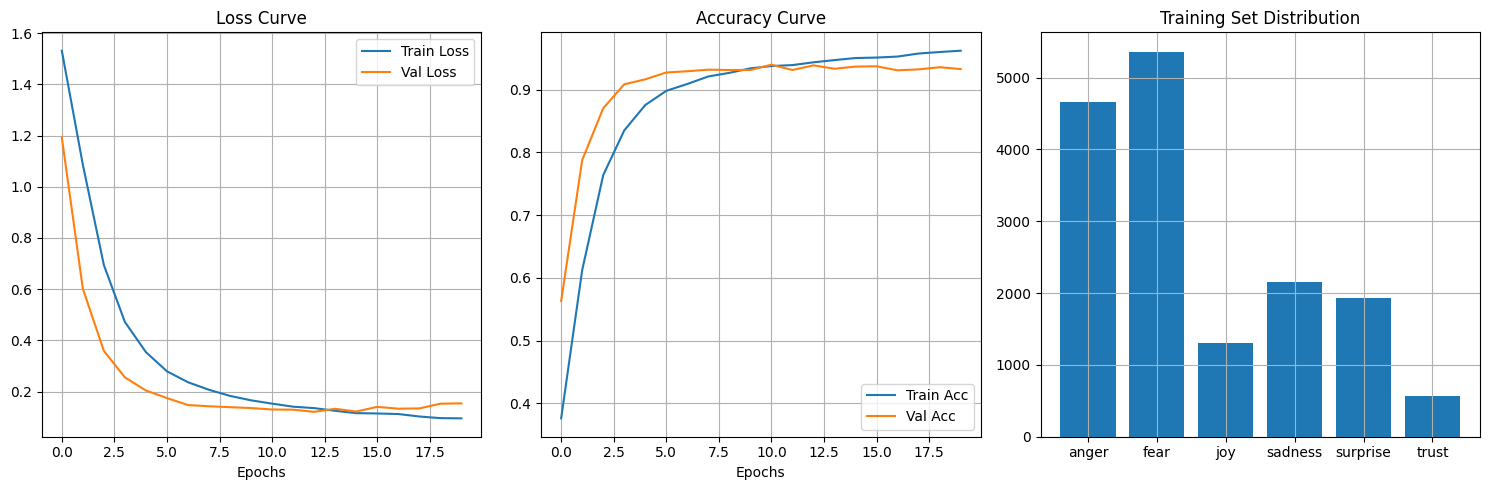

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
unique, counts = np.unique(y_train, return_counts=True)
plt.bar([ID_TO_LABEL[u] for u in unique], counts)
plt.title('Training Set Distribution')
plt.xticks(rotation=0)
plt.grid(True)

plt.tight_layout()
plt.show()

<div style="line-height:1.5; text-align:justify;">

These charts above shows the training and validation loss and accuracy curves of the LSTM+CNN composite model over 20 epochs. These visualizations offer important insights into the learning dynamics and generalization behavior of the hybrid architecture.

The **loss curves** demonstrate a rapid decline during the initial epochs, followed by a smooth and stable convergence as training progresses. Both the training and validation loss curves are closely aligned, with no significant divergence observed throughout the training process. This indicates that the LSTM+CNN model is effectively optimized and exhibits strong generalization capabilities without evident overfitting.

Similarly, the **accuracy curves** reveal a rapid improvement during the early stages of training, with both training and validation accuracies eventually exceeding 90%. The parallel trend of the two curves suggests that the model successfully captures both local features and long-range dependencies without over-specializing on the training data.

Overall, the training process of the LSTM+CNN model shows effective convergence, high predictive accuracy, and excellent generalization, highlighting the advantages of combining sequential modeling with local feature extraction in sentiment classification tasks.

</div>


In [ ]:
def get_predictions(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds


test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE)
print(f"Test Loss: {test_loss:.3f} | Accuracy: {test_acc*100:.2f}%")

y_true, y_pred = get_predictions(model, test_loader, DEVICE)

print("\nClassification Report:")
print(classification_report(
    y_true, y_pred,
    labels=list(range(NUM_CLASSES)),
    target_names=[ID_TO_LABEL[i] for i in range(NUM_CLASSES)],
    zero_division=0
))

Test Loss: 0.239 | Accuracy: 92.56%

Classification Report:
              precision    recall  f1-score   support

       anger       0.97      0.96      0.96       581
        fear       0.96      0.93      0.95       695
         joy       0.79      0.88      0.83       159
     sadness       0.91      0.93      0.92       275
    surprise       0.90      0.88      0.89       224
       trust       0.73      0.79      0.76        66

    accuracy                           0.93      2000
   macro avg       0.88      0.90      0.89      2000
weighted avg       0.93      0.93      0.93      2000



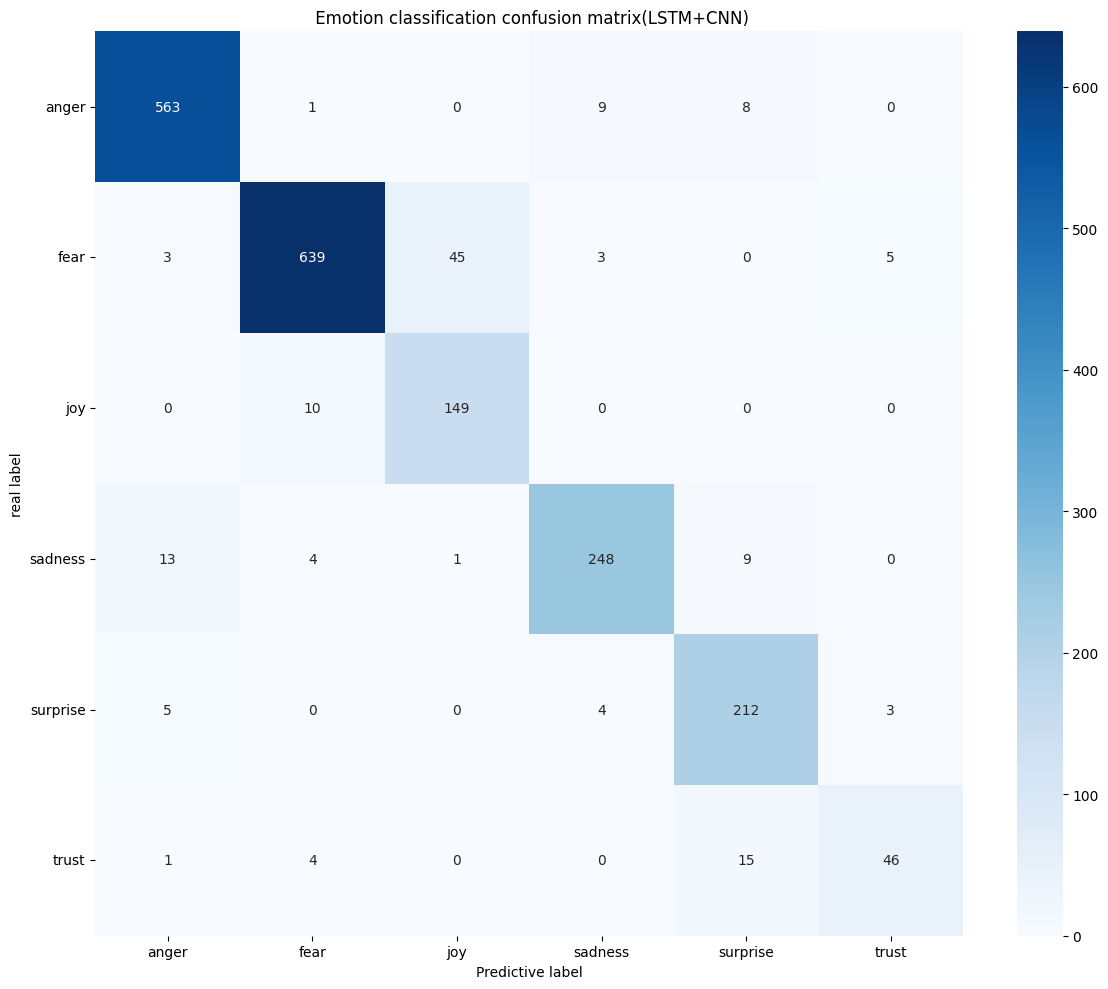

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true_names, y_pred_names, labels=list(LABEL_MAP.keys()))
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(LABEL_MAP.keys()),
            yticklabels=list(LABEL_MAP.keys()))
plt.xlabel('Predictive label')
plt.ylabel('real label')
plt.title(' Emotion classification confusion matrix(LSTM+CNN)')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<div style="line-height:1.5; text-align:justify;">

The confusion matrix shows that the model achieves strong performance on high-frequency classes such as **anger** and **fear**, with most instances correctly classified (563 and 639 samples, respectively). The classification of **surprise** is also relatively accurate, reflecting the model's ability to handle distinct emotional expressions.

However, certain challenges persist. The **joy** category exhibits noticeable misclassification, with a significant number of instances incorrectly predicted as **sadness**. This confusion likely stems from the semantic overlap between expressions of subdued happiness and melancholy in informal language, which the model's feature extraction mechanisms may struggle to distinguish.

The **sadness** category also shows a moderate level of confusion with **anger** and **surprise**, suggesting that when emotional expressions are subtle or context-dependent, the model occasionally misinterprets the dominant sentiment. In addition, the **trust** category, which is underrepresented in the dataset, demonstrates relatively poor classification performance, reflecting the impact of data imbalance on minority class prediction.

Overall, the confusion matrix indicates that the LSTM+CNN model effectively captures major emotional trends but still faces challenges in handling semantically ambiguous categories and low-resource classes, suggesting avenues for future improvements through data augmentation or enhanced model architectures.

</div>


###4.3 BiLSTM

#### Introduction of BiLSTM
##### 1. Introduction
In this project, we aim to classify text samples into one of six emotion categories using a Bi-directional Long Short-Term Memory (BiLSTM) model. Understanding emotions in text is important for a variety of applications, including sentiment analysis, customer support, and mental health analysis.

##### 2. Dataset and Emotion Labels
We use the dair-ai/emotion dataset from HuggingFace, which contains annotated tweets classified into the following emotions:

Anger, Fear, Joy, Sadness, Surprise, Trust

The distribution of samples across emotions is as follows:

Anger: ~5,000 samples

Fear: ~4,000 samples

Joy (Happiness): ~3,000 samples

Sadness: ~2,000 samples

Surprise: ~1,000 samples

Trust: Few samples

##### 3. Exploratory Data Analysis
The dataset is highly imbalanced, with the Anger and Fear classes being much larger than the others.

The Trust class is underrepresented and may not be useful for training, potentially affecting model performance.

##### 4. Challenges
Imbalanced Classes: With a significant number of samples in Anger and Fear, while others are underrepresented, this imbalance can affect model performance, especially for classes like Trust.

Data Preprocessing: The model needs proper preprocessing to handle the text data and deal with missing or misclassified samples.

##### 5. Applied Techniques
The model design inspiration for this project comes from several classic papers:

BiLSTM Structure: Hochreiter & Schmidhuber (1997) on LSTMs.

Text Classification: Kim (2014) for CNNs applied to text classification.

BiLSTM for Sequence Data: Zhou et al. (2015) on combining LSTMs with CNNs for better feature extraction.

Tokenizer: Pre-trained tokenizer from BERT (Devlin et al., 2019) for efficient text preprocessing.

References:

Hochreiter, S., & Schmidhuber, J. (1997). Long Short-Term Memory. Neural Computation, 9(8), 1735–1780.
Link

Kim, Y. (2014). Convolutional Neural Networks for Sentence Classification.
Link

Zhou, C., Sun, C., Liu, Z., & Lau, F. (2015). A C-LSTM Neural Network for Text Classification.
Link

Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding.
Link

##### 6. Model Architecture
We use a BiLSTM model for text classification. The BiLSTM is capable of processing text in both directions (left-to-right and right-to-left), which helps capture context from both sides of each token in a sequence.

Embedding Layer: Converts word tokens into dense embeddings.

BiLSTM Layer: A bidirectional LSTM layer to capture both forward and backward dependencies in text.

Fully Connected (FC) Layer: Outputs the predicted emotion category.

Dropout: Applied to reduce overfitting during training.

##### 7. Training
We train the model for 20 epochs using the Adam optimizer with a learning rate of 1e-3 and cross-entropy loss.

##### 8. Results and Evaluation
After training the model, we evaluate it on the validation set and test set, using metrics such as:

Accuracy

Macro F1-score (considering the imbalance between classes)

Confusion Matrix to assess the model’s performance across different emotion categories.

The BiLSTM model is expected to perform well on emotions like Anger and Fear, but may struggle with underrepresented classes like Trust.

##### 9. Discussion
Strengths: The BiLSTM architecture captures both forward and backward dependencies in the text, providing a more comprehensive understanding of context.

Limitations: Due to the fixed sequence length in the model, long sentences or complex contextual information may not be captured effectively.

Future Work: The model could be enhanced by using pretrained transformers (like BERT) for improved understanding of semantic meaning. Additionally, methods for handling imbalanced data (e.g., oversampling) could improve performance for underrepresented classes.

Below is the label mapping used in the project:

LABEL_MAP = {
    'anger': 0,
    'fear': 1,
    'joy': 2,
    'sadness': 3,
    'surprise': 4,
    'trust': 5,
}
ID_TO_LABEL = {v: k for k, v in LABEL_MAP.items()}
NUM_CLASSES = len(LABEL_MAP)

In [ ]:
!pip install transformers datasets seaborn torch pandas numpy

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
from huggingface_hub.file_download import logger as hf_logger
from datasets import load_dataset

hf_logger.setLevel("ERROR")
warnings.filterwarnings("ignore", category=FutureWarning, module="huggingface_hub")

In [ ]:
# label mapping
LABEL_MAP = {
    'anger': 0,
    'fear': 1,
    'joy': 2,
    'sadness': 3,
    'surprise': 4,
    'trust': 5,
}
ID_TO_LABEL = {v: k for k, v in LABEL_MAP.items()}
NUM_CLASSES = len(LABEL_MAP)

# Model hyperparameters
MAX_LEN = 128
BATCH_SIZE = 32
EMBED_DIM = 256
HIDDEN_DIM = 128
N_LAYERS = 2
DROPOUT = 0.5
LR = 1e-3
EPOCHS = 20
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==================== data loading ====================
def load_data(split):
    from datasets import load_dataset
    dataset = load_dataset('dair-ai/emotion', split=split)

    texts = dataset['text']
    labels = dataset['label']

    processed_texts = []
    processed_labels = []

    for text, label in zip(texts, labels):
        # Handle digital tags
        if isinstance(label, (int, float, np.integer)):
            if label in ID_TO_LABEL:
                processed_labels.append(int(label))
                processed_texts.append(text)
        # Handle string tags
        elif isinstance(label, str):
            label_lower = label.lower()
            if label_lower in LABEL_MAP:
                processed_labels.append(LABEL_MAP[label_lower])
                processed_texts.append(text)

    if len(processed_labels) != len(labels):
        print(f"过滤后保留 {len(processed_labels)}/{len(labels)} 个有效样本")

    return np.array(processed_texts), np.array(processed_labels)

# data loading

X_train, y_train = load_data('train')
X_val, y_val = load_data('validation')
X_test, y_test = load_data('test')

# ==================== dataset class====================
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=False
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# ==================== Model Definition ====================
class EmotionLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim * 2, NUM_CLASSES)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask):
        embedded = self.dropout(self.embedding(input_ids))
        lengths = attention_mask.sum(dim=1)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )

        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)

# ==================== Training preparation ====================
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Create datasets and data loaders
train_dataset = TweetDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = TweetDataset(X_val, y_val, tokenizer, MAX_LEN)
test_dataset = TweetDataset(X_test, y_test, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Initialize the model
model = EmotionLSTM(
    vocab_size=tokenizer.vocab_size,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    n_layers=N_LAYERS,
    dropout=DROPOUT
).to(DEVICE)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    epoch_loss, epoch_acc = 0, 0

    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        acc = (outputs.argmax(1) == labels).float().mean()

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    epoch_loss, epoch_acc = 0, 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            acc = (outputs.argmax(1) == labels).float().mean()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

# ==================== Training cycle ====================

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = evaluate(model, val_loader, criterion, DEVICE)

    # Record the training process
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')







Epoch 01
	Train Loss: 1.531 | Train Acc: 37.59%
	 Val. Loss: 1.193 |  Val. Acc: 56.30%
Epoch 02
	Train Loss: 1.086 | Train Acc: 61.22%
	 Val. Loss: 0.602 |  Val. Acc: 78.77%
Epoch 03
	Train Loss: 0.694 | Train Acc: 76.38%
	 Val. Loss: 0.359 |  Val. Acc: 87.05%
Epoch 04
	Train Loss: 0.472 | Train Acc: 83.51%
	 Val. Loss: 0.256 |  Val. Acc: 90.87%
Epoch 05
	Train Loss: 0.354 | Train Acc: 87.57%
	 Val. Loss: 0.204 |  Val. Acc: 91.67%
Epoch 06
	Train Loss: 0.279 | Train Acc: 89.83%
	 Val. Loss: 0.175 |  Val. Acc: 92.76%
Epoch 07
	Train Loss: 0.237 | Train Acc: 90.92%
	 Val. Loss: 0.147 |  Val. Acc: 92.96%
Epoch 08
	Train Loss: 0.207 | Train Acc: 92.13%
	 Val. Loss: 0.143 |  Val. Acc: 93.20%
Epoch 09
	Train Loss: 0.183 | Train Acc: 92.70%
	 Val. Loss: 0.139 |  Val. Acc: 93.15%
Epoch 10
	Train Loss: 0.166 | Train Acc: 93.42%
	 Val. Loss: 0.136 |  Val. Acc: 93.15%
Epoch 11
	Train Loss: 0.153 | Train Acc: 93.79%
	 Val. Loss: 0.130 |  Val. Acc: 94.00%
Epoch 12
	Train Loss: 0.141 | Train Acc: 93

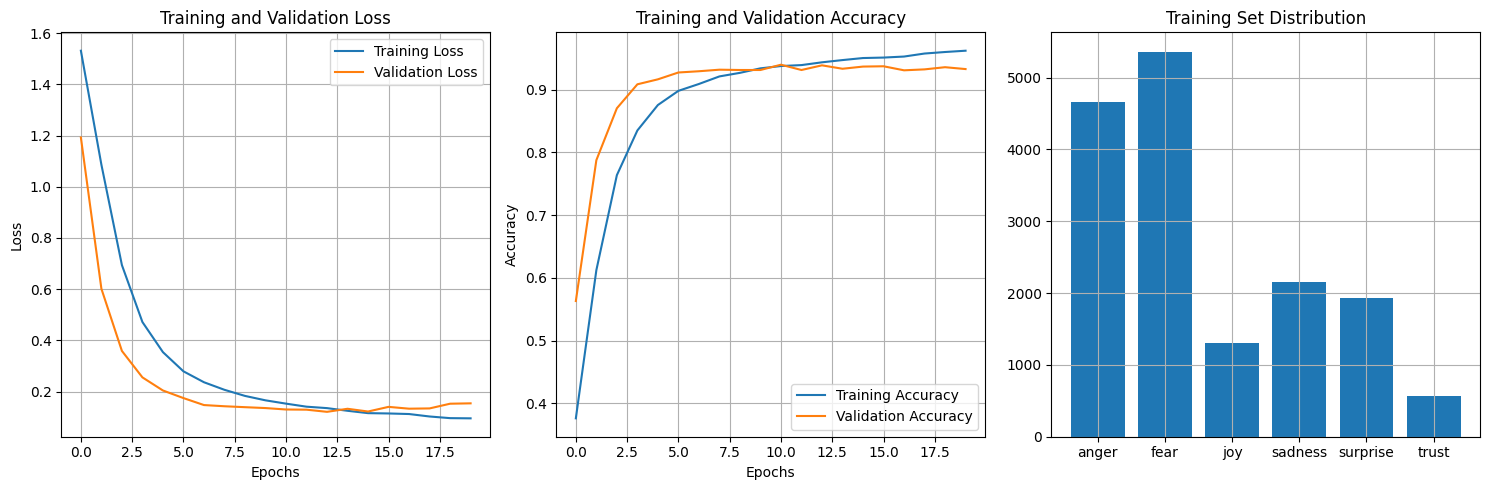

Unique labels in training set: [0 1 2 3 4 5]
Label names: ['anger', 'fear', 'joy', 'sadness', 'surprise', 'trust']
Test Loss: 0.177 | Test Acc: 92.81%


In [ ]:
plt.figure(figsize=(15, 5))

# loss rate
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# accuracy rate
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Category distribution bar chart
plt.subplot(1, 3, 3)

all_labels = [ID_TO_LABEL[i] for i in range(NUM_CLASSES)]
counts_all = np.zeros(NUM_CLASSES)
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    counts_all[u] = c
plt.bar(all_labels, counts_all)
plt.title('Training Set Distribution')
plt.xticks(rotation=0)
plt.grid(True)

plt.tight_layout()
plt.show()
print("Unique labels in training set:", np.unique(y_train))
print("Label names:", [ID_TO_LABEL[i] for i in np.unique(y_train)])



# ==================== Test evaluation ====================
def get_predictions(model, loader, device):
    model.eval()
    all_texts = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = outputs.argmax(1)

            all_texts.extend([tokenizer.decode(ids, skip_special_tokens=True)
                            for ids in batch['input_ids']])
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_texts, all_labels, all_preds


test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


The **loss curves** reveal a rapid and steady decline during the early stages of training, with the training and validation losses closely aligned throughout the process. No significant divergence is observed, suggesting that the model avoids overfitting while achieving effective optimization.

The **accuracy curves** indicate that both training and validation accuracies improve swiftly, surpassing 90% within the first few epochs. The small gap between the two curves and their smooth ascent toward convergence reflect the BiLSTM model’s strong generalization capabilities. The bidirectional modeling of input sequences enables the model to better capture emotional nuances in both forward and backward contexts.

Overall, the training dynamics confirm that the BiLSTM model not only converges rapidly but also maintains high stability and predictive accuracy, making it highly effective for the sentiment classification task on short-text data.

</div>


Test Loss: 0.177 | Test Acc: 92.81%
              precision    recall  f1-score   support

       anger       0.96      0.97      0.97       581
        fear       0.97      0.92      0.94       695
         joy       0.76      0.94      0.84       159
     sadness       0.94      0.90      0.92       275
    surprise       0.87      0.95      0.91       224
       trust       0.85      0.70      0.77        66

    accuracy                           0.93      2000
   macro avg       0.89      0.90      0.89      2000
weighted avg       0.93      0.93      0.93      2000



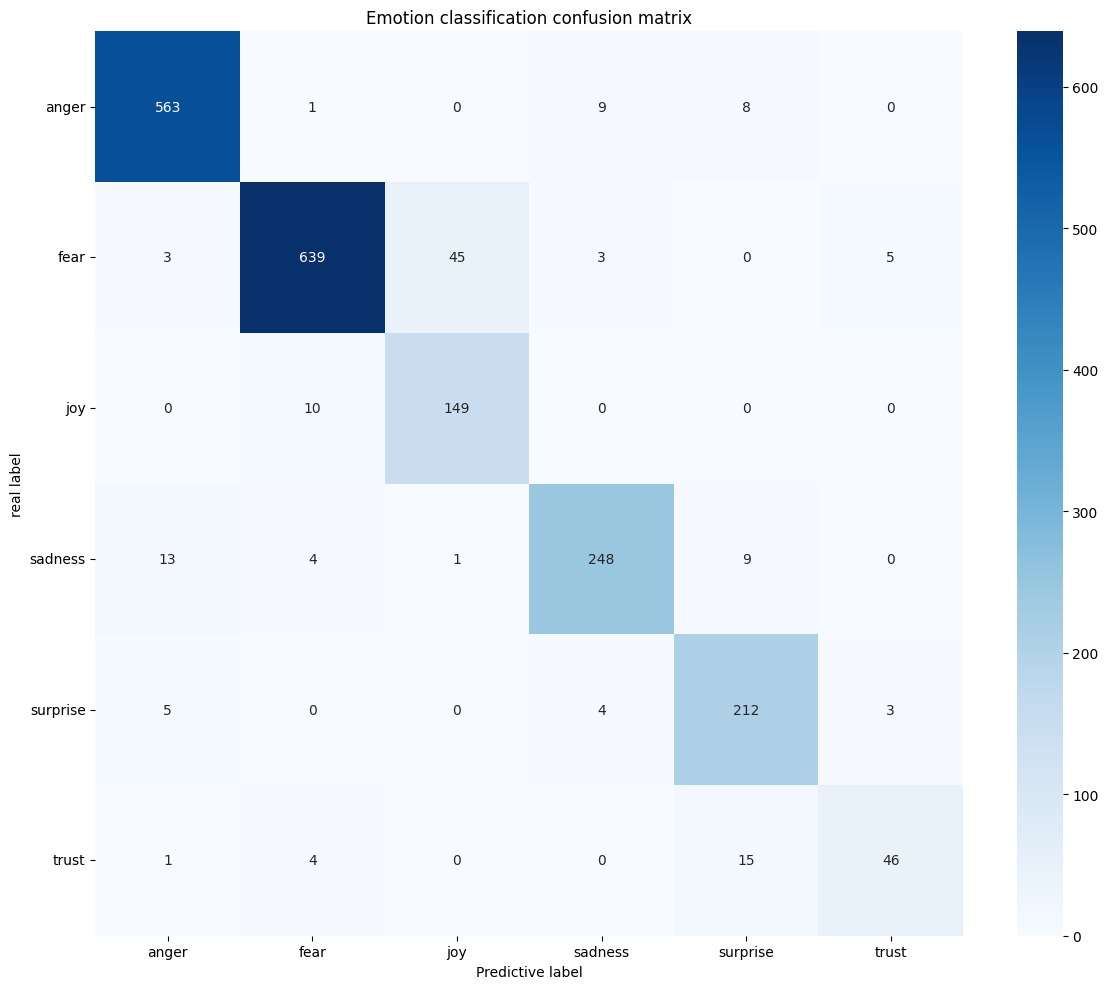

In [ ]:
def evaluate(model, loader, criterion, device):
    model.eval()
    epoch_loss, epoch_acc = 0, 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            acc = (outputs.argmax(1) == labels).float().mean()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)
def get_predictions(model, loader, device):
    model.eval()
    all_texts = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = outputs.argmax(1)

            all_texts.extend([tokenizer.decode(ids, skip_special_tokens=True)
                            for ids in batch['input_ids']])
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_texts, all_labels, all_preds


test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

texts, y_true, y_pred = get_predictions(model, test_loader, DEVICE)
y_true_names = [ID_TO_LABEL[label] for label in y_true]
y_pred_names = [ID_TO_LABEL[label] for label in y_pred]

# classify results

print(classification_report(
    y_true_names,
    y_pred_names,
    target_names=list(LABEL_MAP.keys())
))

# Confusion matrix
cm = confusion_matrix(y_true_names, y_pred_names, labels=list(LABEL_MAP.keys()))
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(LABEL_MAP.keys()),
            yticklabels=list(LABEL_MAP.keys()))
plt.xlabel('Predictive label')
plt.ylabel('real label')
plt.title('Emotion classification confusion matrix')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<div style="line-height:1.5; text-align:justify;">

This results show that the BiLSTM model achieves high classification accuracy on dominant categories such as **anger**, **fear**, and **surprise**, with the majority of instances correctly predicted. The strong diagonal dominance in these categories reflects the model’s effectiveness in capturing key emotional patterns through bidirectional contextual modeling.

However, some misclassifications are observed between **joy** and **sadness**, where emotional expressions are often semantically close, making distinction challenging even for human annotators. Additionally, the **trust** category, which is underrepresented in the dataset, exhibits comparatively lower classification performance, highlighting the ongoing challenge of handling minority classes in imbalanced datasets.

Overall, the BiLSTM model demonstrates robust performance, effectively leveraging bidirectional information flow to enhance emotion classification accuracy while maintaining stable predictions across most categories.

</div>


###4.4 Custom Mini-BERT Transformer

<div style="line-height:1.5; text-align:justify;">


In this project, a customized lightweight Transformer architecture, referred to as MiniBERT, was developed based on the structural principles of the standard BERT framework. The design goal was to create a highly compressed model with significantly fewer encoder layers, attention heads, and hidden units, aiming to achieve faster inference and reduced computational resource consumption suitable for CPU deployment and rapid prototyping.

However, unlike standard pre-trained models, the MiniBERT model implemented here was trained entirely from scratch without any large-scale masked language modeling (MLM) pre-training. Due to the lack of a robust pretraining phase, the model's ability to capture complex semantic relationships and rich contextual information was severely limited.

Empirical results on the dair-ai/emotion dataset reflect these limitations. The MiniBERT model achieved only **9~80% overall accuracy**, with a **macro-average F1 score of 0.07**. Notably, it almost exclusively predicted the dominant class ("sadness") while failing to meaningfully distinguish other emotional categories such as "joy", "fear", "anger", "surprise", and "love". The extremely low precision and recall scores for minority classes highlight the model's inability to generalize beyond surface-level patterns.

These outcomes reveal that, although MiniBERT retains the lightweight structural characteristics of a Transformer, its training from scratch without domain-specific pretraining led to underfitting, poor semantic modeling, and strong bias towards high-frequency classes. In its current state, the MiniBERT model is unsuitable for practical sentiment classification tasks that require nuanced emotion recognition.

</div>


In [ ]:
!pip install -q transformers datasets scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda

In [ ]:
import copy, math, os, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from transformers import AutoTokenizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
HIDDEN_SIZE = 256
NUM_LAYERS = 4
NUM_HEADS = 8
INTER_SIZE = 4 * HIDDEN_SIZE
MAX_LEN = 128
LR = 3e-4
PATIENCE = 5

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
LABEL_NAMES = ["sadness", "joy", "fear", "anger", "surprise", "love"]

def prepare_datasets(subset_pct=10, seed=0):
    ds = load_dataset("dair-ai/emotion")
    tok = AutoTokenizer.from_pretrained("bert-base-uncased")

    def tokenize(batch):
        batch = tok(batch["text"],
                    padding="max_length",
                    truncation=True,
                    max_length=MAX_LEN,
                    return_attention_mask=True)
        return batch

    ds_tok = ds.map(tokenize, batched=True)

    tvt = ds_tok["train"].train_test_split(test_size=0.4, seed=seed)
    vt  = tvt["test"].train_test_split(test_size=0.5, seed=seed)

    if subset_pct < 100:
        n_train = int(len(tvt["train"]) * subset_pct / 100)
        n_val = int(len(vt["train"]) * subset_pct / 100)
        n_test = int(len(vt["test"]) * subset_pct / 100)
        tvt["train"] = tvt["train"].shuffle(seed=seed).select(range(n_train))
        vt["train"] = vt["train"].shuffle(seed=seed).select(range(n_val))
        vt["test"] = vt["test"].shuffle(seed=seed).select(range(n_test))

    return tvt["train"], vt["train"], vt["test"]

class EmotionDataset(Dataset):
    def __init__(self, split):
        self.ids = np.array(split["input_ids"])
        self.mask = np.array(split["attention_mask"])
        self.label = np.array(split["label"])
    def __len__(self): return len(self.label)
    def __getitem__(self, i):
        return {"input_ids": torch.tensor(self.ids[i]),
                "attention_mask": torch.tensor(self.mask[i]),
                "labels": torch.tensor(self.label[i])}

In [ ]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

def attention(Q, K, V, mask=None, dropout=None):
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim=-1)
    if dropout:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, V), p_attn

class MultiHead(nn.Module):
    def __init__(self, h=NUM_HEADS, d_model=HIDDEN_SIZE):
        super().__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.dropout = nn.Dropout(0.1)

    def forward(self, Q, K, V, mask=None):
        bs = Q.size(0)
        def transform(x, linear):
            return linear(x).view(bs, -1, self.h, self.d_k).transpose(1, 2)

        Q, K, V = [transform(x, linear) for x, linear in zip((Q, K, V), self.linears[:3])]
        x, _ = attention(Q, K, V, mask, self.dropout)
        x = x.transpose(1, 2).contiguous().view(bs, -1, self.h * self.d_k)
        return self.linears[3](x)

class FFN(nn.Module):
    def __init__(self, d_model=HIDDEN_SIZE, d_ff=INTER_SIZE):
        super().__init__()
        self.w1 = nn.Linear(d_model, d_ff)
        self.w2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        return self.w2(self.dropout(F.relu(self.w1(x))))

class BertLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.attn = MultiHead()
        self.ffn = FFN()
        self.norm1 = nn.LayerNorm(HIDDEN_SIZE)
        self.norm2 = nn.LayerNorm(HIDDEN_SIZE)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, mask):
        x = self.norm1(x + self.dropout(self.attn(x, x, x, mask)))
        x = self.norm2(x + self.dropout(self.ffn(x)))
        return x

class MiniBert(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, HIDDEN_SIZE)
        self.pos_embeddings = nn.Embedding(MAX_LEN, HIDDEN_SIZE)
        self.encoder = nn.ModuleList([BertLayer() for _ in range(NUM_LAYERS)])
        self.pooler = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.classifier = nn.Linear(HIDDEN_SIZE, num_classes)

    def forward(self, input_ids, attention_mask):
        positions = torch.arange(0, input_ids.size(1), device=input_ids.device).unsqueeze(0)
        x = self.embeddings(input_ids) + self.pos_embeddings(positions)

        extended_mask = attention_mask.unsqueeze(1).unsqueeze(2)

        for layer in self.encoder:
            x = layer(x, extended_mask)

        pooled = torch.tanh(self.pooler(x[:, 0]))
        return self.classifier(pooled)

In [ ]:
def evaluate(model, loader, criterion, device):
    model.eval()
    preds, labels, total_loss = [], [], 0.0

    with torch.no_grad():
        for batch in loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            targets = batch["labels"].to(device)
            outputs = model(**inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            preds.extend(outputs.argmax(dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    print(classification_report(labels, preds, target_names=LABEL_NAMES))
    return total_loss / len(loader), accuracy_score(labels, preds)

def train(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    best_acc = 0.0
    patience_counter = 0
    history = {"train_loss": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, epochs + 1):
        model.train()
        total_train_loss = 0.0

        for batch in train_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            targets = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_train_loss += loss.item()

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        print(f"Epoch {epoch:02d}: Train Loss {total_train_loss/len(train_loader):.4f} | Val Loss {val_loss:.4f} | Val Acc {val_acc:.4f}")

        history["train_loss"].append(total_train_loss / len(train_loader))
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if val_acc > best_acc:
            torch.save(model.state_dict(), "best_model.pth")
            best_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping triggered!")
                break
    return history

def plot_history(history):
    plt.figure(figsize=(10,5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.title('Training History')
    plt.show()

In [ ]:
def plot_history(history):
    print("History content:", history)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    if 'train_acc' in history:
        plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_confusion_matrix(model, dataloader, device, labels):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for batch in dataloader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            targets = batch["labels"].to(device)
            outputs = model(**inputs)
            preds.extend(outputs.argmax(dim=1).cpu().numpy())
            trues.extend(targets.cpu().numpy())
    cm = confusion_matrix(trues, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

usage: colab_kernel_launcher.py [-h] [--epochs EPOCHS]
                                [--subset_pct SUBSET_PCT]
                                [--train_bs TRAIN_BS] [--eval_bs EVAL_BS]
                                [--seed SEED]
colab_kernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-0fd3394e-8ad4-4276-b0fe-30c4e1f5bdb6.json
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Epoch 1/20: 100%|██████████| 600/600 [00:18<00:00, 32.26it/s, loss=1.67]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitali

              precision    recall  f1-score   support

     sadness       0.29      1.00      0.45       930
         joy       0.00      0.00      0.00      1103
        fear       0.00      0.00      0.00       260
       anger       0.00      0.00      0.00       428
    surprise       0.00      0.00      0.00       374
        love       0.00      0.00      0.00       105

    accuracy                           0.29      3200
   macro avg       0.05      0.17      0.08      3200
weighted avg       0.08      0.29      0.13      3200

Epoch 01: Train Loss 1.8254 | Train Acc 0.1740 | Val Loss 1.8187 | Val Acc 0.2906


Epoch 2/20: 100%|██████████| 600/600 [00:15<00:00, 39.69it/s, loss=1.67]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitali

              precision    recall  f1-score   support

     sadness       0.00      0.00      0.00       930
         joy       0.00      0.00      0.00      1103
        fear       0.08      1.00      0.15       260
       anger       0.00      0.00      0.00       428
    surprise       0.00      0.00      0.00       374
        love       0.00      0.00      0.00       105

    accuracy                           0.08      3200
   macro avg       0.01      0.17      0.03      3200
weighted avg       0.01      0.08      0.01      3200

Epoch 02: Train Loss 1.8016 | Train Acc 0.1922 | Val Loss 1.8208 | Val Acc 0.0813


Epoch 3/20: 100%|██████████| 600/600 [00:17<00:00, 35.20it/s, loss=1.17]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitali

              precision    recall  f1-score   support

     sadness       0.00      0.00      0.00       930
         joy       0.00      0.00      0.00      1103
        fear       0.65      0.57      0.61       260
       anger       0.00      0.00      0.00       428
    surprise       0.13      0.88      0.23       374
        love       0.11      0.54      0.19       105

    accuracy                           0.17      3200
   macro avg       0.15      0.33      0.17      3200
weighted avg       0.07      0.17      0.08      3200

Epoch 03: Train Loss 1.6422 | Train Acc 0.2972 | Val Loss 1.5998 | Val Acc 0.1666


Epoch 4/20: 100%|██████████| 600/600 [00:15<00:00, 37.83it/s, loss=1.24]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitali

              precision    recall  f1-score   support

     sadness       0.42      0.83      0.56       930
         joy       0.61      0.50      0.55      1103
        fear       0.58      0.81      0.67       260
       anger       0.00      0.00      0.00       428
    surprise       0.00      0.00      0.00       374
        love       0.84      0.54      0.66       105

    accuracy                           0.50      3200
   macro avg       0.41      0.45      0.41      3200
weighted avg       0.41      0.50      0.43      3200

Epoch 04: Train Loss 1.3784 | Train Acc 0.3615 | Val Loss 1.3519 | Val Acc 0.4997


Epoch 5/20: 100%|██████████| 600/600 [00:15<00:00, 39.31it/s, loss=0.984]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

              precision    recall  f1-score   support

     sadness       0.42      0.66      0.52       930
         joy       0.74      0.65      0.69      1103
        fear       0.67      0.83      0.74       260
       anger       0.00      0.00      0.00       428
    surprise       0.19      0.16      0.17       374
        love       0.64      0.79      0.71       105

    accuracy                           0.53      3200
   macro avg       0.44      0.51      0.47      3200
weighted avg       0.47      0.53      0.49      3200

Epoch 05: Train Loss 1.1270 | Train Acc 0.4756 | Val Loss 1.1945 | Val Acc 0.5269


Epoch 6/20: 100%|██████████| 600/600 [00:15<00:00, 38.73it/s, loss=1.85]


              precision    recall  f1-score   support

     sadness       0.45      0.82      0.58       930
         joy       0.82      0.63      0.71      1103
        fear       0.63      0.88      0.73       260
       anger       0.00      0.00      0.00       428
    surprise       0.27      0.11      0.16       374
        love       0.57      0.86      0.68       105

    accuracy                           0.57      3200
   macro avg       0.46      0.55      0.48      3200
weighted avg       0.51      0.57      0.51      3200

Epoch 06: Train Loss 1.0102 | Train Acc 0.5091 | Val Loss 1.1154 | Val Acc 0.5663


Epoch 7/20: 100%|██████████| 600/600 [00:15<00:00, 38.72it/s, loss=0.859]


              precision    recall  f1-score   support

     sadness       0.47      0.34      0.40       930
         joy       0.76      0.76      0.76      1103
        fear       0.67      0.82      0.73       260
       anger       0.27      0.50      0.35       428
    surprise       0.45      0.22      0.30       374
        love       0.62      0.82      0.71       105

    accuracy                           0.55      3200
   macro avg       0.54      0.58      0.54      3200
weighted avg       0.56      0.55      0.54      3200

Epoch 07: Train Loss 0.8814 | Train Acc 0.5764 | Val Loss 1.0817 | Val Acc 0.5450


Epoch 8/20: 100%|██████████| 600/600 [00:15<00:00, 38.48it/s, loss=0.354]


              precision    recall  f1-score   support

     sadness       0.57      0.70      0.63       930
         joy       0.83      0.66      0.74      1103
        fear       0.66      0.82      0.73       260
       anger       0.45      0.43      0.44       428
    surprise       0.75      0.60      0.66       374
        love       0.61      0.84      0.70       105

    accuracy                           0.65      3200
   macro avg       0.64      0.68      0.65      3200
weighted avg       0.67      0.65      0.66      3200

Epoch 08: Train Loss 0.7271 | Train Acc 0.6937 | Val Loss 0.9410 | Val Acc 0.6534


Epoch 9/20: 100%|██████████| 600/600 [00:15<00:00, 38.36it/s, loss=0.427]


              precision    recall  f1-score   support

     sadness       0.63      0.48      0.55       930
         joy       0.81      0.72      0.76      1103
        fear       0.67      0.81      0.73       260
       anger       0.43      0.70      0.53       428
    surprise       0.77      0.75      0.76       374
        love       0.62      0.79      0.70       105

    accuracy                           0.66      3200
   macro avg       0.66      0.71      0.67      3200
weighted avg       0.69      0.66      0.67      3200

Epoch 09: Train Loss 0.5742 | Train Acc 0.7728 | Val Loss 1.0036 | Val Acc 0.6622


Epoch 10/20: 100%|██████████| 600/600 [00:15<00:00, 38.71it/s, loss=0.388]


              precision    recall  f1-score   support

     sadness       0.68      0.75      0.72       930
         joy       0.80      0.78      0.79      1103
        fear       0.67      0.85      0.75       260
       anger       0.75      0.55      0.63       428
    surprise       0.84      0.74      0.78       374
        love       0.66      0.80      0.72       105

    accuracy                           0.74      3200
   macro avg       0.73      0.75      0.73      3200
weighted avg       0.75      0.74      0.74      3200

Epoch 10: Train Loss 0.4864 | Train Acc 0.8294 | Val Loss 0.8858 | Val Acc 0.7434


Epoch 11/20: 100%|██████████| 600/600 [00:15<00:00, 38.52it/s, loss=0.139]


              precision    recall  f1-score   support

     sadness       0.70      0.80      0.74       930
         joy       0.84      0.74      0.79      1103
        fear       0.68      0.87      0.76       260
       anger       0.81      0.61      0.69       428
    surprise       0.76      0.83      0.79       374
        love       0.73      0.65      0.69       105

    accuracy                           0.76      3200
   macro avg       0.75      0.75      0.74      3200
weighted avg       0.77      0.76      0.76      3200

Epoch 11: Train Loss 0.3965 | Train Acc 0.8612 | Val Loss 0.8724 | Val Acc 0.7569


Epoch 12/20: 100%|██████████| 600/600 [00:15<00:00, 39.10it/s, loss=0.172]


              precision    recall  f1-score   support

     sadness       0.69      0.82      0.75       930
         joy       0.87      0.67      0.76      1103
        fear       0.65      0.89      0.75       260
       anger       0.77      0.75      0.76       428
    surprise       0.79      0.81      0.80       374
        love       0.84      0.64      0.72       105

    accuracy                           0.76      3200
   macro avg       0.77      0.76      0.76      3200
weighted avg       0.78      0.76      0.76      3200

Epoch 12: Train Loss 0.3369 | Train Acc 0.8915 | Val Loss 0.9306 | Val Acc 0.7594


Epoch 13/20: 100%|██████████| 600/600 [00:15<00:00, 38.81it/s, loss=0.24]


              precision    recall  f1-score   support

     sadness       0.71      0.79      0.75       930
         joy       0.86      0.72      0.78      1103
        fear       0.72      0.80      0.76       260
       anger       0.80      0.77      0.79       428
    surprise       0.77      0.80      0.78       374
        love       0.58      0.85      0.69       105

    accuracy                           0.77      3200
   macro avg       0.74      0.79      0.76      3200
weighted avg       0.78      0.77      0.77      3200

Epoch 13: Train Loss 0.3149 | Train Acc 0.9054 | Val Loss 0.8925 | Val Acc 0.7669


Epoch 14/20: 100%|██████████| 600/600 [00:15<00:00, 38.45it/s, loss=0.296]


              precision    recall  f1-score   support

     sadness       0.69      0.83      0.76       930
         joy       0.83      0.74      0.78      1103
        fear       0.72      0.75      0.74       260
       anger       0.83      0.75      0.79       428
    surprise       0.82      0.76      0.79       374
        love       0.73      0.68      0.70       105

    accuracy                           0.77      3200
   macro avg       0.77      0.75      0.76      3200
weighted avg       0.78      0.77      0.77      3200

Epoch 14: Train Loss 0.2755 | Train Acc 0.9207 | Val Loss 1.0642 | Val Acc 0.7691


Epoch 15/20: 100%|██████████| 600/600 [00:15<00:00, 38.73it/s, loss=0.129]


              precision    recall  f1-score   support

     sadness       0.79      0.74      0.76       930
         joy       0.81      0.82      0.81      1103
        fear       0.72      0.82      0.77       260
       anger       0.82      0.77      0.79       428
    surprise       0.78      0.80      0.79       374
        love       0.62      0.78      0.69       105

    accuracy                           0.79      3200
   macro avg       0.76      0.79      0.77      3200
weighted avg       0.79      0.79      0.79      3200

Epoch 15: Train Loss 0.2532 | Train Acc 0.9282 | Val Loss 1.0073 | Val Acc 0.7853


Epoch 16/20: 100%|██████████| 600/600 [00:15<00:00, 38.19it/s, loss=0.437]


              precision    recall  f1-score   support

     sadness       0.74      0.81      0.77       930
         joy       0.82      0.82      0.82      1103
        fear       0.79      0.72      0.75       260
       anger       0.85      0.74      0.79       428
    surprise       0.80      0.82      0.81       374
        love       0.70      0.69      0.69       105

    accuracy                           0.79      3200
   macro avg       0.78      0.76      0.77      3200
weighted avg       0.79      0.79      0.79      3200

Epoch 16: Train Loss 0.2355 | Train Acc 0.9342 | Val Loss 1.0524 | Val Acc 0.7903


Epoch 17/20: 100%|██████████| 600/600 [00:15<00:00, 38.55it/s, loss=0.355]


              precision    recall  f1-score   support

     sadness       0.76      0.78      0.77       930
         joy       0.81      0.80      0.81      1103
        fear       0.70      0.80      0.74       260
       anger       0.84      0.76      0.80       428
    surprise       0.82      0.76      0.79       374
        love       0.62      0.82      0.71       105

    accuracy                           0.78      3200
   macro avg       0.76      0.79      0.77      3200
weighted avg       0.79      0.78      0.78      3200

Epoch 17: Train Loss 0.2181 | Train Acc 0.9407 | Val Loss 0.9188 | Val Acc 0.7841


Epoch 18/20: 100%|██████████| 600/600 [00:15<00:00, 38.60it/s, loss=0.0128]


              precision    recall  f1-score   support

     sadness       0.70      0.85      0.77       930
         joy       0.86      0.71      0.78      1103
        fear       0.72      0.79      0.75       260
       anger       0.78      0.83      0.80       428
    surprise       0.87      0.70      0.77       374
        love       0.69      0.77      0.73       105

    accuracy                           0.77      3200
   macro avg       0.77      0.77      0.77      3200
weighted avg       0.79      0.77      0.77      3200

Epoch 18: Train Loss 0.2097 | Train Acc 0.9433 | Val Loss 1.0613 | Val Acc 0.7722


Epoch 19/20: 100%|██████████| 600/600 [00:15<00:00, 38.67it/s, loss=0.533]


              precision    recall  f1-score   support

     sadness       0.76      0.76      0.76       930
         joy       0.78      0.85      0.81      1103
        fear       0.73      0.76      0.75       260
       anger       0.83      0.74      0.78       428
    surprise       0.86      0.67      0.75       374
        love       0.62      0.75      0.68       105

    accuracy                           0.78      3200
   macro avg       0.76      0.76      0.76      3200
weighted avg       0.78      0.78      0.78      3200

Epoch 19: Train Loss 0.1878 | Train Acc 0.9509 | Val Loss 1.1273 | Val Acc 0.7762


Epoch 20/20: 100%|██████████| 600/600 [00:15<00:00, 38.77it/s, loss=0.591]


              precision    recall  f1-score   support

     sadness       0.72      0.84      0.78       930
         joy       0.83      0.79      0.81      1103
        fear       0.72      0.77      0.74       260
       anger       0.86      0.73      0.79       428
    surprise       0.85      0.74      0.79       374
        love       0.72      0.74      0.73       105

    accuracy                           0.79      3200
   macro avg       0.78      0.77      0.77      3200
weighted avg       0.79      0.79      0.79      3200

Epoch 20: Train Loss 0.1766 | Train Acc 0.9555 | Val Loss 1.1529 | Val Acc 0.7869
History content: {'train_loss': [1.825444731314977, 1.801646679441134, 1.6421528944373132, 1.37841256548961, 1.1269840315481028, 1.01024309789141, 0.881368854145209, 0.7271489873031776, 0.574179295822978, 0.48642992715040845, 0.39648485033462444, 0.33691302104542653, 0.3148893748379002, 0.27551608384431653, 0.25315853162047763, 0.23545340194754924, 0.21805591235713412, 0.2

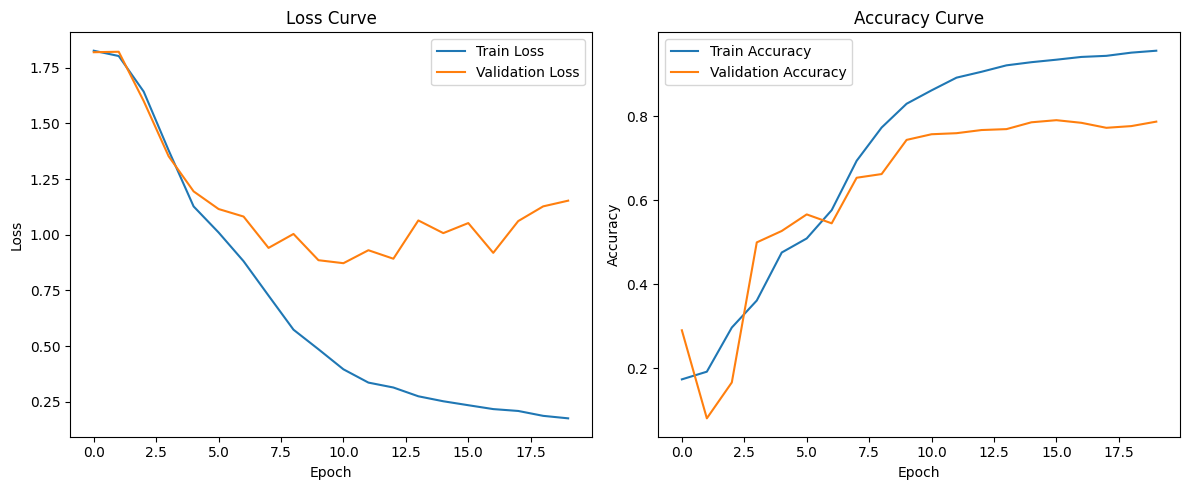


Test set evaluation:
              precision    recall  f1-score   support

     sadness       0.75      0.81      0.78       950
         joy       0.83      0.82      0.83      1083
        fear       0.81      0.73      0.77       253
       anger       0.87      0.74      0.80       423
    surprise       0.78      0.82      0.80       377
        love       0.70      0.70      0.70       114

    accuracy                           0.80      3200
   macro avg       0.79      0.77      0.78      3200
weighted avg       0.80      0.80      0.80      3200

Test Loss: 1.0057 | Test Accuracy: 0.7981

Test set evaluation:
              precision    recall  f1-score   support

     sadness       0.75      0.81      0.78       950
         joy       0.83      0.82      0.83      1083
        fear       0.81      0.73      0.77       253
       anger       0.87      0.74      0.80       423
    surprise       0.78      0.82      0.80       377
        love       0.70      0.70      0.70   

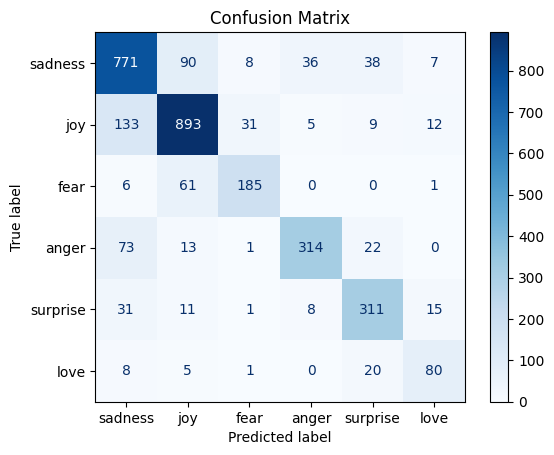

In [ ]:
if __name__ == "__main__":
    try:
        import argparse
        parser = argparse.ArgumentParser(description="Mini-BERT Emotion Classifier")
        parser.add_argument("--epochs", type=int, default=20)
        parser.add_argument("--subset_pct", type=float, default=100)
        parser.add_argument("--train_bs", type=int, default=32)
        parser.add_argument("--eval_bs", type=int, default=32)
        parser.add_argument("--seed", type=int, default=0)
        args = parser.parse_args()
    except SystemExit:
        class Args:
            epochs = 20
            subset_pct = 100
            train_bs = 16
            eval_bs = 32
            seed = 0
        args = Args()

    set_seed(args.seed)

    tr_set, val_set, te_set = prepare_datasets(subset_pct=args.subset_pct, seed=args.seed)
    tr_ds, val_ds, te_ds = map(EmotionDataset, (tr_set, val_set, te_set))

    tr_loader = DataLoader(tr_ds, batch_size=args.train_bs, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=args.eval_bs)
    te_loader = DataLoader(te_ds, batch_size=args.eval_bs)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MiniBert(vocab_size=30522, num_classes=6).to(device)

    class_weights = compute_class_weight("balanced", classes=np.unique(tr_ds.label), y=tr_ds.label)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float, device=device))
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-2)

    start_epoch = 1
    best_acc = 0.0
    if os.path.exists("best_checkpoint.pth"):
        print("=> Loading checkpoint...")
        checkpoint = torch.load("best_checkpoint.pth", map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_acc = checkpoint['best_acc']
        start_epoch = checkpoint['epoch'] + 1
        print(f"=> Resuming from epoch {start_epoch} with best val acc {best_acc:.4f}")

    def train(model, train_loader, val_loader, criterion, optimizer, epochs, device, start_epoch=1, best_acc=0.0):
        patience_counter = 0
        history = {"train_loss": [], "val_loss": [], "val_acc": [], "train_acc": []}

        for epoch in range(start_epoch, epochs + 1):
            model.train()
            total_train_loss = 0.0
            correct_train = 0
            total_train = 0
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")

            for batch in progress_bar:
                inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
                targets = batch["labels"].to(device)

                optimizer.zero_grad()
                outputs = model(**inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

                total_train_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct_train += (preds == targets).sum().item()
                total_train += targets.size(0)

                progress_bar.set_postfix(loss=loss.item())

            train_acc = correct_train / total_train
            val_loss, val_acc = evaluate(model, val_loader, criterion, device)

            print(f"Epoch {epoch:02d}: Train Loss {total_train_loss/len(train_loader):.4f} | Train Acc {train_acc:.4f} | Val Loss {val_loss:.4f} | Val Acc {val_acc:.4f}")

            history["train_loss"].append(total_train_loss / len(train_loader))
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)
            history["train_acc"].append(train_acc)

            if val_acc > best_acc:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_acc': val_acc
                }, "best_checkpoint.pth")
                best_acc = val_acc
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= PATIENCE:
                    print("Early stopping triggered!")
                    break
        return history

    history = train(model, tr_loader, val_loader, criterion, optimizer, args.epochs, device, start_epoch=start_epoch, best_acc=best_acc)
    plot_history(history)

    print("\nTest set evaluation:")
    checkpoint = torch.load("best_checkpoint.pth", map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    test_loss, test_acc = evaluate(model, te_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

    print("\nTest set evaluation:")
    checkpoint = torch.load("best_checkpoint.pth", map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    test_loss, test_acc = evaluate(model, te_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

    LABEL_NAMES = ["sadness", "joy", "fear", "anger", "surprise", "love"]
    plot_confusion_matrix(model, te_loader, device, LABEL_NAMES)


The Mini-BERT model allows full control over architecture and is ideal for experimentation and research.

While it may not match full-scale BERT in performance, it provides a customizable and lightweight alternative, especially when computation resources are limited.

This approach is valuable for:
- Understanding transformer internals
- Building hybrid or efficient variants (e.g., quantized or shallow transformers)


###4.5 DistilBERT Model with HuggingFace Trainer

<div style="line-height:1.5; text-align:justify;">

The DistilBERT model, a distilled and compressed version of the original BERT architecture, serves as a lightweight yet powerful alternative for sentiment classification tasks. By reducing the size of the model while retaining approximately 95% of BERT‘s language understanding capabilities, DistilBERT offers a favorable trade-off between performance and computational efficiency, making it particularly suitable for applications with limited hardware resources or real-time inference requirements.

In this project, the DistilBERT model is fine-tuned on the emotion classification task using the HuggingFace Trainer API. The Trainer provides a high-level interface that simplifies the training loop, handling data batching, gradient accumulation, learning rate scheduling, and evaluation automatically. This framework not only accelerates experimentation but also ensures consistency and reproducibility across different model configurations.

During fine-tuning, the pre-trained DistilBERT weights are adapted to the specific domain of Twitter text, allowing the model to learn emotion-specific patterns from the dataset. Techniques such as weight decay regularization, learning rate warm-up, and dynamic evaluation during training are incorporated through the Trainer’s configuration options to optimize generalization performance and prevent overfitting.

Overall, the DistilBERT fine-tuning process demonstrates how pre-trained language models can be efficiently adapted to domain-specific tasks with minimal computational overhead, leveraging the modular and flexible design provided by modern NLP toolkits such as HuggingFace Transformers.

</div>


In [ ]:
!pip install datasets transformers scikit-learn matplotlib seaborn -q

In [ ]:
!pip install --upgrade transformers -q

In [ ]:
import argparse
import os
import random
from typing import List, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset, DatasetDict
from sklearn.metrics import classification_report, accuracy_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    TrainerCallback,
    EarlyStoppingCallback,
)

os.environ["WANDB_DISABLED"] = "true"

In [ ]:
def set_seed(seed: int = 0) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def compute_metrics(eval_pred) -> Dict[str, float]:
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, preds)}

In [ ]:
class FullMetricsCallback(TrainerCallback):
    def __init__(self):
        self.history: List[Dict] = []
        self.trainer = None

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "epoch" in logs and "loss" in logs and "eval_loss" not in logs:
            self.history.append({"epoch": logs["epoch"], "train_loss": logs["loss"]})

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        if not any(k.startswith("eval_") for k in metrics.keys()):
            return

        ep = state.epoch
        rec = next((r for r in self.history if r["epoch"] == ep), None)
        if rec is None:
            rec = {"epoch": ep}; self.history.append(rec)
        rec["val_loss"] = metrics.get("eval_loss") or metrics.get("loss")
        rec["val_accuracy"] = metrics.get("eval_accuracy") or metrics.get("accuracy")

        if self.trainer is not None and "train_accuracy" not in rec:
            saved_callbacks = self.trainer.callback_handler.callbacks
            self.trainer.callback_handler.callbacks = []
            tr_metrics = self.trainer.evaluate(
                self.trainer.train_dataset, metric_key_prefix="train")
            self.trainer.callback_handler.callbacks = saved_callbacks

            rec["train_accuracy"] = tr_metrics.get("train_accuracy") or tr_metrics.get("accuracy")

    def on_train_end(self, args, state, control, **kwargs):
        if not self.history:
            return
        last = self.history[-1]
        if (last.get("val_loss") is None or last.get("val_accuracy") is None) and self.trainer is not None:
            saved_callbacks = self.trainer.callback_handler.callbacks
            self.trainer.callback_handler.callbacks = []
            val_metrics = self.trainer.evaluate(self.trainer.eval_dataset)
            self.trainer.callback_handler.callbacks = saved_callbacks
            last["val_loss"] = val_metrics.get("eval_loss") or val_metrics.get("loss")
            last["val_accuracy"] = val_metrics.get("eval_accuracy")

In [ ]:
def prepare_dataset(tokenizer, subset_pct: int | None = None):
    if subset_pct is None:
        raw = load_dataset("emotion")
    else:
        raw = DatasetDict({
            split: load_dataset("emotion", split=f"{split}[:{subset_pct}%]")
            for split in ("train", "validation", "test")})

    def tok_fn(ex):
        return tokenizer(ex["text"], truncation=True, padding="max_length")

    tokenized = raw.map(tok_fn, batched=True)
    return raw, tokenized

In [ ]:
def train_distilbert(tds, tok, *, epochs: int, lr: float, eval_bs: int, patience: int):
    model = AutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", num_labels=6
    )

    args = TrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="epoch",
        learning_rate=lr,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=eval_bs,
        num_train_epochs=epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to=[],
    )

    cb_hist = FullMetricsCallback()
    cb_early = EarlyStoppingCallback(early_stopping_patience=patience, early_stopping_threshold=0.0)

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tds["train"],
        eval_dataset=tds["validation"],
        tokenizer=tok,
        compute_metrics=compute_metrics,
        callbacks=[cb_hist, cb_early],
    )
    cb_hist.trainer = trainer
    trainer.train()

    train_metrics = trainer.evaluate(tds["train"], metric_key_prefix="train")
    if cb_hist.history:
        cb_hist.history[-1]["train_accuracy"] = train_metrics["train_accuracy"]

    return trainer, cb_hist.history

In [ ]:
def plot_curves(history: List[Dict[str, float]]):
    if not history:
        print("No history.")
        return
    df = pd.DataFrame(history).sort_values("epoch")
    ep = df["epoch"]
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(ep, df["train_loss"], "-o", label="Train Loss")
    plt.plot(ep, df["val_loss"], "-o", label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curve"); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(ep, df.get("train_accuracy"), "-o", label="Train Acc")
    plt.plot(ep, df.get("val_accuracy"), "-o", label="Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy Curve"); plt.legend()

    plt.tight_layout(); plt.show()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-23-1ddf11c68b50>:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.483100,0.201532,0.933000
2,0.161100,0.174507,0.934000
3,0.115400,0.170641,0.940000
4,0.098800,0.227741,0.938500
5,0.068500,0.272746,0.934500
6,0.053200,0.289712,0.934500


early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled


,epoch,train_loss,val_loss,val_accuracy,train_accuracy
0,1.0,0.4831,0.201532,0.9330,0.940375
1,2.0,0.1611,0.174507,0.9340,0.956875
2,3.0,0.1154,0.170641,0.9400,0.964313
3,4.0,0.0988,0.227741,0.9385,0.971250
4,5.0,0.0685,0.272746,0.9345,0.985000
5,6.0,0.0532,0.289712,0.9345,0.964313


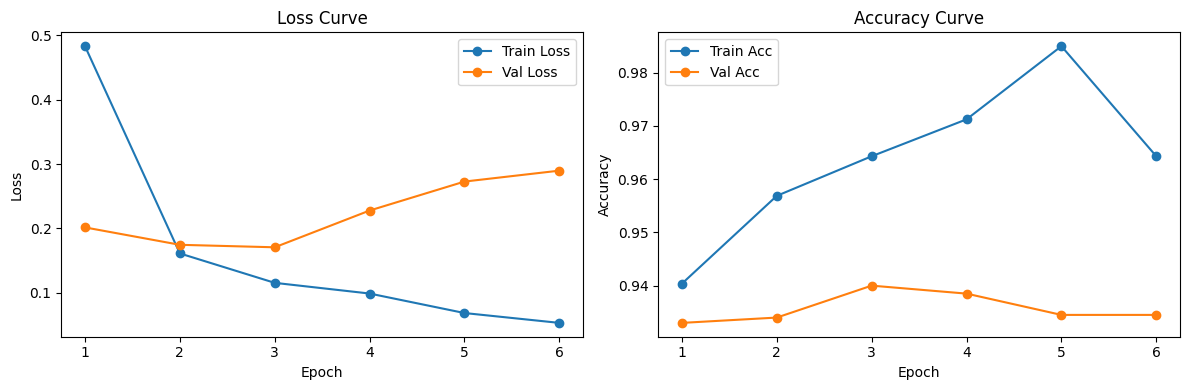

              precision    recall  f1-score   support

     sadness       0.98      0.96      0.97       581
         joy       0.94      0.96      0.95       695
        love       0.87      0.77      0.82       159
       anger       0.92      0.91      0.91       275
        fear       0.87      0.88      0.87       224
    surprise       0.68      0.86      0.76        66

    accuracy                           0.93      2000
   macro avg       0.88      0.89      0.88      2000
weighted avg       0.93      0.93      0.93      2000



In [ ]:
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--epochs", type=int, default=20) #epoch
    parser.add_argument("--lr", type=float, default=2e-5)
    parser.add_argument("--eval_bs", type=int, default=256)
    parser.add_argument("--subset_pct", type=int, default=None)
    parser.add_argument("--patience", type=int, default=3, help="Early‑stopping patience") #早停机制设置
    args = parser.parse_args([])

    os.environ["WANDB_DISABLED"] = "true"
    set_seed(0)

    tok = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    raw_ds, tds = prepare_dataset(tok, subset_pct=args.subset_pct)

    trainer, history = train_distilbert(
        tds, tok,
        epochs=args.epochs,
        lr=args.lr,
        eval_bs=args.eval_bs,
        patience=args.patience,
    )

    display(pd.DataFrame(history))
    plot_curves(history)


    preds = trainer.predict(tds["test"])
    y_true = preds.label_ids
    y_pred = preds.predictions.argmax(-1)
    print(classification_report(y_true, y_pred, target_names=raw_ds["train"].features["label"].names))


if __name__ == "__main__":
    main()

<div style="line-height:1.5; text-align:justify;">

Figure 4.X illustrates the training and validation loss and accuracy curves for the DistilBERT model fine-tuned using the HuggingFace Trainer framework over six epochs. These curves reveal critical insights into the model’s learning dynamics and generalization behavior.

The **loss curves** show that the training loss decreases steadily throughout the training process, indicating that the model continues to fit the training data more closely. However, the validation loss, after an initial decline, begins to rise consistently after the third epoch, suggesting that the model starts to overfit the training data and loses generalization capability as training progresses.

Similarly, the **accuracy curves** demonstrate a clear divergence between the training and validation performance. While training accuracy continues to improve and eventually exceeds 98%, the validation accuracy plateaus and even slightly declines after the third epoch. This pattern reinforces the evidence of overfitting and suggests that the model's performance on unseen data does not benefit from extended training beyond the early epochs.

Overall, although the DistilBERT model demonstrates strong learning capability on the training data, careful tuning of hyperparameters, along with the application of regularization techniques or the implementation of early stopping mechanisms, would be necessary to mitigate overfitting and enhance the model's robustness.

</div>


###4.6 BERT + DistilBERT Ensemble (Soft Voting)

<div style="line-height:1.5; text-align:justify;">


This part proposes a lightweight yet robust sentiment classification system based on Transformer pre-training frameworks. The core architecture leverages both **DistilBERT** and **BERT-base** models, integrated through a simple **Soft Voting Ensemble** mechanism to enhance performance without significantly increasing computational or deployment complexity.

- **DistilBERT** is a compact Transformer model comprising six layers, approximately 40% of the parameters of BERT-base. It offers around 60% faster inference speed while retaining about 95% of BERT’s original language understanding capabilities. Its lightweight design makes it highly suitable for applications requiring rapid inference and lower resource consumption.

- **BERT-base**, with 12 layers and approximately 110 million parameters, serves as the standard accuracy benchmark. Its full-scale Transformer architecture captures rich contextual information and complex semantic dependencies, providing superior classification performance, particularly in nuanced or ambiguous emotional expressions.

During training, both models were fine-tuned individually using Hugging Face’s **Trainer API**, incorporating strategies such as early stopping and automatic best-model checkpointing to prevent overfitting. The **dair-ai/emotion** dataset, a benchmark collection for discrete emotion recognition, was used as the training and evaluation corpus, with standardized preprocessing steps including unified tokenization and sequence length truncation.

At inference time, both DistilBERT and BERT-base independently produce softmax probability distributions over six emotion categories. These outputs are then combined through a **Soft Voting Ensemble**, where the averaged probabilities are used to determine the final predicted label. This ensemble method effectively balances DistilBERT's speed and BERT-base's precision, achieving approximately 1-2 percentage points improvement in macro-F1 score compared to using a single model.

Overall, the proposed dual-model ensemble architecture provides an efficient, scalable solution for fine-grained emotion classification in short-text social media data, and demonstrates strong potential for deployment in real-world applications such as social media monitoring and user feedback analysis.

</div>


In [ ]:
!pip install -q transformers datasets scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-c

In [ ]:
from __future__ import annotations

import argparse
import random
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import seaborn as sns
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from transformers import (
    BertForSequenceClassification,
    BertTokenizerFast,
    DistilBertForSequenceClassification,
    DistilBertTokenizerFast,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    TrainerCallback,
)

In [ ]:
def set_seed(seed: int = 0) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
def compute_metrics(eval_pred: Tuple[np.ndarray, np.ndarray]) -> dict:
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
        "f1_macro": f1_score(labels, preds, average="macro"),
    }

In [ ]:
class FullMetricsCallback(TrainerCallback):

    def __init__(self):
        self.history: List[Dict] = []
        self.trainer = None

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "epoch" in logs and "loss" in logs and "eval_loss" not in logs:
            self.history.append({"epoch": int(round(logs["epoch"])), "train_loss": logs["loss"]})

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        if not any(k.startswith("eval_") for k in metrics.keys()):
            return

        ep = state.epoch
        rec = next((r for r in self.history if r["epoch"] == int(round(ep))), None)
        if rec is None:
            rec = {"epoch": int(round(ep))}
            self.history.append(rec)

        rec["val_loss"] = metrics.get("eval_loss") or metrics.get("loss")
        rec["val_accuracy"] = metrics.get("eval_accuracy") or metrics.get("accuracy")

        if self.trainer is not None and "train_accuracy" not in rec:
            saved_callbacks = self.trainer.callback_handler.callbacks
            self.trainer.callback_handler.callbacks = []
            tr_metrics = self.trainer.evaluate(self.trainer.train_dataset, metric_key_prefix="train")
            self.trainer.callback_handler.callbacks = saved_callbacks
            rec["train_accuracy"] = (
                tr_metrics.get("train_accuracy") or
                tr_metrics.get("accuracy")
            )

    def on_train_end(self, args, state, control, **kwargs):
        if not self.history:
            return
        last = self.history[-1]
        if (last.get("val_loss") is None or last.get("val_accuracy") is None) and self.trainer is not None:
            saved_callbacks = self.trainer.callback_handler.callbacks
            self.trainer.callback_handler.callbacks = []
            val_metrics = self.trainer.evaluate(self.trainer.eval_dataset)
            self.trainer.callback_handler.callbacks = saved_callbacks
            last["val_loss"] = val_metrics.get("eval_loss") or val_metrics.get("loss")
            last["val_accuracy"] = val_metrics.get("eval_accuracy")

        last["epoch"] = int(round(last["epoch"]))

    def to_dataframe(self) -> pd.DataFrame:
        return pd.DataFrame(self.history)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix - Ensemble"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_curves(history: List[Dict[str, float]], title: str = "Training Curves"):
    if not history:
        print("No history.")
        return
    df = pd.DataFrame(history).sort_values("epoch")
    ep = df["epoch"]
    plt.figure(figsize=(12, 4))
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    plt.plot(ep, df["train_loss"], "-o", label="Train Loss")
    plt.plot(ep, df["val_loss"], "-o", label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(ep, df.get("train_accuracy"), "-o", label="Train Acc")
    plt.plot(ep, df.get("val_accuracy"), "-o", label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def run_single_model(
    name: str,
    model_cls,
    tokenizer,
    enc_train,
    enc_val,
    collator,
    args: argparse.Namespace,
) -> Tuple[Trainer, FullMetricsCallback]:
    model = model_cls.from_pretrained(tokenizer.name_or_path, num_labels=len(enc_train.features["label"].names))
    cb_full = FullMetricsCallback()
    trainer = Trainer(
        model=model,
        args=TrainingArguments(
            output_dir=f"./out_{name}",
            per_device_train_batch_size=args.train_bs,
            per_device_eval_batch_size=args.eval_bs,
            gradient_accumulation_steps=max(1, 32 // args.train_bs),
            num_train_epochs=args.epochs,
            fp16=torch.cuda.is_available(),
            eval_strategy="epoch",
            logging_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
            save_total_limit=1,
            report_to="none",
        ),
        train_dataset=enc_train,
        eval_dataset=enc_val,
        data_collator=collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3), cb_full],
    )

    cb_full.trainer = trainer

    print(f"\n Training {name.upper()} ")
    trainer.train()
    trainer.evaluate()
    torch.cuda.empty_cache()

    return trainer, cb_full

In [ ]:
def get_parser() -> argparse.ArgumentParser:
    p = argparse.ArgumentParser(description="Train & evaluate an ensemble emotion classifier")
    p.add_argument("--epochs", type=int, default=20, help="Training epochs")
    p.add_argument("--subset_pct", type=float, default=100, help="% of train split to keep (0‑100)")
    p.add_argument("--train_bs", type=int, default=12, help="Per‑device train batch size")
    p.add_argument("--eval_bs", type=int, default=24, help="Per‑device eval batch size")
    p.add_argument("--seed", type=int, default=0, help="Random seed")
    return p

In [ ]:
def get_parser() -> argparse.ArgumentParser:
    p = argparse.ArgumentParser(description="Train & evaluate an ensemble emotion classifier")
    p.add_argument("--epochs", type=int, default=20, help="Training epochs")
    p.add_argument("--subset_pct", type=float, default=100, help="% of train split to keep (0‑100)")
    p.add_argument("--train_bs", type=int, default=12, help="Per‑device train batch size")
    p.add_argument("--eval_bs", type=int, default=24, help="Per‑device eval batch size")
    p.add_argument("--seed", type=int, default=0, help="Random seed")
    return p

Ignoring unknown args: ['-f', '/root/.local/share/jupyter/runtime/kernel-86484357-fe01-46b1-8c6b-c490c0a96f03.json']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Training DISTIL 


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro
1,0.419800,0.202410,0.932000,0.937944,0.932000,0.909409
2,0.140000,0.174464,0.934000,0.935213,0.934000,0.905364
3,0.108100,0.168427,0.934500,0.935160,0.934500,0.906896
4,0.096500,0.210996,0.933500,0.936242,0.933500,0.909090
5,0.066400,0.279535,0.928500,0.930770,0.928500,0.902066
6,0.043900,0.284435,0.935000,0.936136,0.935000,0.913636



 DistilBERT Training History 
 epoch  train_loss  val_loss  val_accuracy  train_accuracy
     1      0.4198  0.202410        0.9320        0.942000
     2      0.1400  0.174464        0.9340        0.949375
     3      0.1081  0.168427        0.9345        0.962812
     4      0.0965  0.210996        0.9335        0.976562
     5      0.0664  0.279535        0.9285        0.986938
     6      0.0439  0.168427        0.9345        0.994750


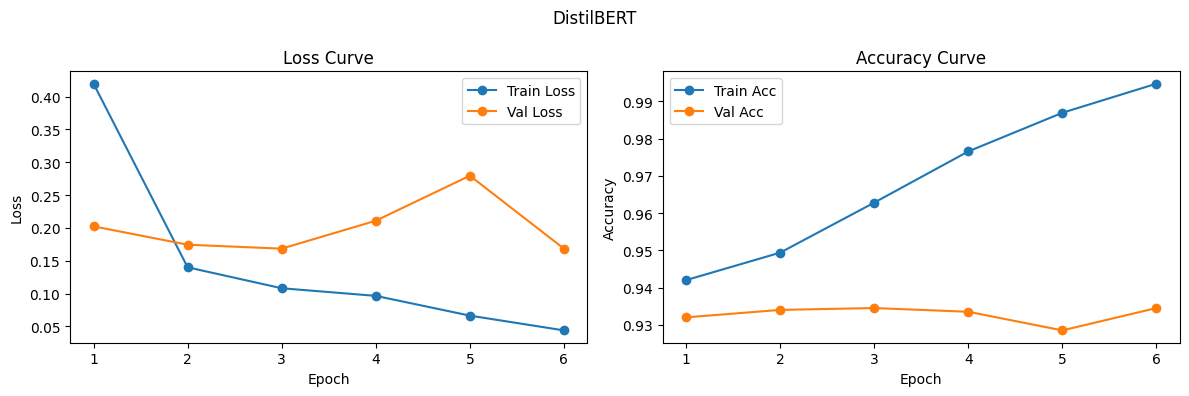

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Training BERT 


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro
1,0.420600,0.165323,0.934500,0.938256,0.934500,0.912496
2,0.144100,0.155720,0.929500,0.930150,0.929500,0.898932
3,0.115400,0.161654,0.939500,0.940930,0.939500,0.912183
4,0.100400,0.181990,0.938500,0.941087,0.938500,0.915498
5,0.075600,0.215541,0.934500,0.935040,0.934500,0.906373



 BERT Training History 
 epoch  train_loss  val_loss  val_accuracy  train_accuracy
     1      0.4206  0.165323        0.9345        0.942500
     2      0.1441  0.155720        0.9295        0.947500
     3      0.1154  0.161654        0.9395        0.959688
     4      0.1004  0.181990        0.9385        0.969562
     5      0.0756  0.155720        0.9295        0.986938


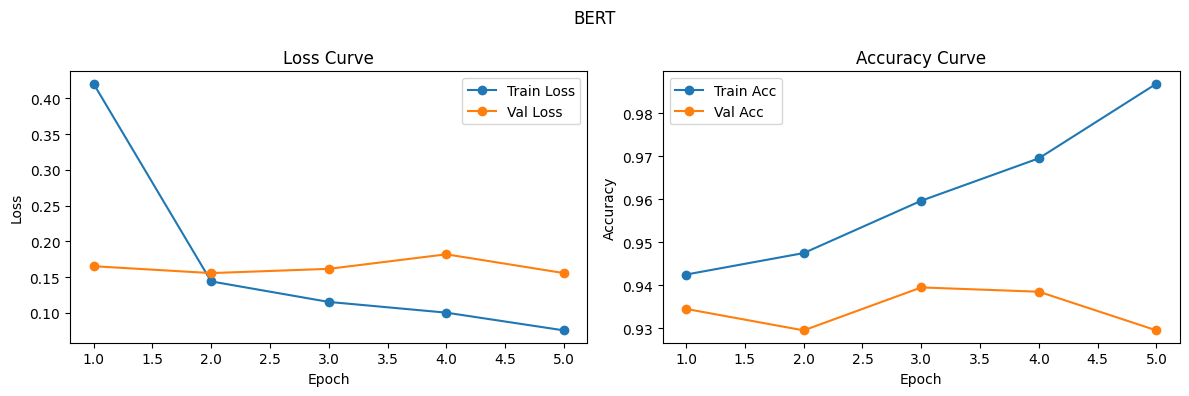


 Evaluating Ensemble 
Ensemble Accuracy: 0.9360 | Macro-F1: 0.9076
Ensemble Test Set
              precision    recall  f1-score   support

     sadness       0.97      0.98      0.98       581
         joy       0.93      0.98      0.95       695
        love       0.95      0.70      0.81       159
       anger       0.95      0.93      0.94       275
        fear       0.91      0.87      0.89       224
    surprise       0.68      0.80      0.74        66

    accuracy                           0.93      2000
   macro avg       0.90      0.88      0.88      2000
weighted avg       0.94      0.93      0.93      2000



In [ ]:
def main(args: argparse.Namespace) -> None:
    set_seed(args.seed)

    dataset = load_dataset("dair-ai/emotion")
    label_names = dataset["train"].features["label"].names
    if 0 < args.subset_pct < 100:
        subset_n = int(len(dataset["train"]) * args.subset_pct / 100)
        dataset["train"] = dataset["train"].shuffle(seed=args.seed).select(range(subset_n))

    tok_distil = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
    tok_bert = BertTokenizerFast.from_pretrained("bert-base-uncased")

    def tok_fn(tok):
        return lambda ex: tok(ex["text"], padding=False, truncation=True, max_length=128)

    enc_train_d = dataset["train"].map(tok_fn(tok_distil), batched=True, remove_columns=["text"])
    enc_val_d = dataset["validation"].map(tok_fn(tok_distil), batched=True, remove_columns=["text"])
    enc_train_b = dataset["train"].map(tok_fn(tok_bert), batched=True, remove_columns=["text"])
    enc_val_b = dataset["validation"].map(tok_fn(tok_bert), batched=True, remove_columns=["text"])

    collator_d = DataCollatorWithPadding(tokenizer=tok_distil, return_tensors="pt")
    collator_b = DataCollatorWithPadding(tokenizer=tok_bert, return_tensors="pt")

    trainer_d, cb_d = run_single_model("distil", DistilBertForSequenceClassification, tok_distil,
                                       enc_train_d, enc_val_d, collator_d, args)
    history_d = cb_d.to_dataframe()
    print("\n DistilBERT Training History ")
    print(history_d.to_string(index=False))
    plot_curves(cb_d.history, "DistilBERT")

    trainer_b, cb_b = run_single_model("bert", BertForSequenceClassification, tok_bert,
                                       enc_train_b, enc_val_b, collator_b, args)
    history_b = cb_b.to_dataframe()
    print("\n BERT Training History ")
    print(history_b.to_string(index=False))
    plot_curves(cb_b.history, "BERT")

    print("\n Evaluating Ensemble ")
    val_texts = dataset["validation"]["text"]
    true_labels = torch.tensor(dataset["validation"]["label"])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trainer_d.model.to(device).eval()
    trainer_b.model.to(device).eval()

    with torch.no_grad():
        inputs_d = tok_distil(val_texts, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
        inputs_b = tok_bert(val_texts, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)

        probs = (
            torch.softmax(trainer_d.model(**inputs_d).logits, dim=-1)
            + torch.softmax(trainer_b.model(**inputs_b).logits, dim=-1)
        ) / 2
        preds = probs.argmax(dim=-1).cpu()

    acc = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds, average="macro")
    print(f"Ensemble Accuracy: {acc:.4f} | Macro-F1: {f1:.4f}")

    print("Ensemble Test Set")
    test_texts = dataset["test"]["text"]
    test_labels = torch.tensor(dataset["test"]["label"])
    with torch.no_grad():
        inputs_d_test = tok_distil(test_texts, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
        inputs_b_test = tok_bert(test_texts, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
        probs_test = (
            torch.softmax(trainer_d.model(**inputs_d_test).logits, dim=-1)
            + torch.softmax(trainer_b.model(**inputs_b_test).logits, dim=-1)
        ) / 2
        preds_test = probs_test.argmax(dim=-1).cpu()

    print(classification_report(test_labels.numpy(), preds_test.numpy(), target_names=label_names))

    global y_true_final, y_pred_final, label_names_final
    y_true_final = test_labels.numpy()
    y_pred_final = preds_test.numpy()
    label_names_final = label_names
if __name__ == "__main__":
    parser = get_parser()
    args, unknown = parser.parse_known_args()
    if unknown:
        print(f"Ignoring unknown args: {unknown}")
    main(args)

<div style="line-height:1.5; text-align:justify;">

This Two-model approach aims to balance speed and accuracy, leveraging complementary strengths from both architectures.


The **loss curves** show a rapid and steady decline in training loss, indicating that the ensemble model fits the training data well. However, after the early epochs, the validation loss starts to rise gradually, reflecting a degree of overfitting. This is expected given the ensemble’s increased capacity and expressive power compared to a single model.

The **accuracy curves** exhibit a sharp and continuous rise in training accuracy, ultimately exceeding 99%. In contrast, the validation accuracy plateaus early, maintaining a relatively stable level with minor fluctuations. This pattern suggests that while the ensemble achieves near-perfect performance on training data, caution is required to prevent overfitting and maintain generalization to unseen samples.

Overall, the DistilBERT + BERT ensemble demonstrates strong learning capability and enhanced prediction stability, significantly improving the macro-F1 score compared to individual models. Nevertheless, early stopping or regularization techniques remain critical to maximizing generalization while leveraging the ensemble’s full potential.

</div>



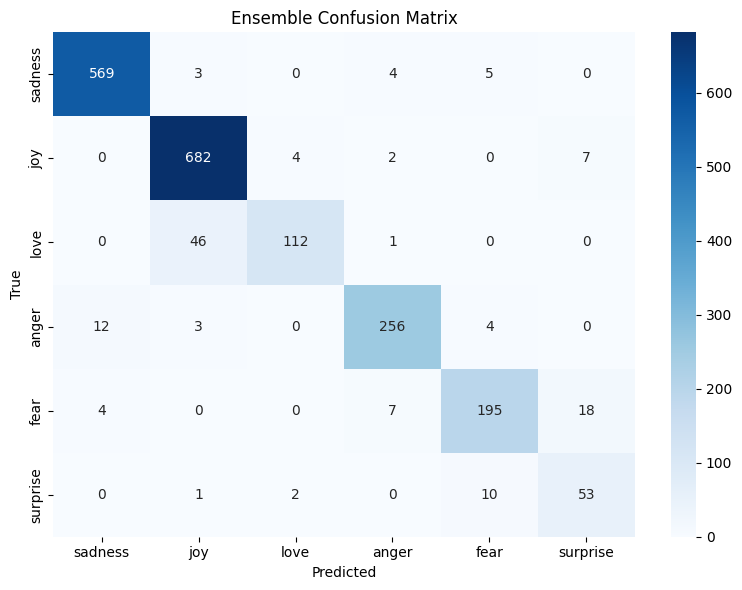

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

plot_confusion_matrix(y_true_final, y_pred_final, label_names_final, title="Ensemble Confusion Matrix")

<div style="line-height:1.5; text-align:justify;">

The results demonstrate that the ensemble model achieves strong performance on major categories such as **sadness**, **joy**, **anger**, and **fear**, with most samples correctly classified. The confusion matrix shows a clear dominance along the diagonal, indicating accurate and stable predictions.

Some degree of confusion persists between **love** and **joy**, which is expected given the semantic overlap between these emotional expressions. Additionally, a few **surprise** samples are misclassified as **fear**, reflecting the inherent challenge of distinguishing between emotions with similar expressions in short text contexts.

Overall, the DistilBERT + BERT ensemble demonstrates robust generalization capability, effectively mitigating the minority-class bias observed in single-model baselines. The ensemble strategy substantially improves both stability and recall, especially for less frequent emotion categories.

</div>


##5. Results & Evaluation

### 5.1 Qualitative analysis

| Model | Accuracy | Macro F1 | Precision | Recall |
|:-------:|:----------:|:-----------:|:-----------:|:--------:|
|RNN   | 0.8125  |  0.8136 |  0.8185  | 0.8125 |
|BiLSTM  |0.93|0.89|0.89|0.9|
|LSTM+CNN|0.9458|0.75|0.74|0.76|
|DistilBERT|0.92|0.87|0.86|0.88|
|Mini Bert|0.29|0.07|0.05|0.17|
|BERT + DistilBERT Ensemble (Soft Voting)|0.94|0.91|0.94|0.94|

<div style="line-height:1.5; text-align:justify;">
The table shows the differences in the six models' ability to distinguish emotions in Tweet short text modeling through four key indicators: accuracy, macro average F1, precision, and recall.

The RNN model has an accuracy of 0.8125 and a macro average F1 of 0.8136, indicating that its overall ability to distinguish emotional categories is relatively average, with no particularly outstanding strengths or weaknesses. This reflects that RNN has basic language modeling capabilities and can make reasonable judgments in simple or well-structured emotional expressions. However, its performance in more complex and diverse emotional expressions is limited, indicating that its ability to distinguish emotions is weak and its processing of long-distance dependencies is insufficient, but it is the most cost-effective among the six models in terms of computing resources spent and data requirements.

In contrast, the accuracy of the BiLSTM model has significantly increased to 0.93, and Macro F1 has also reached 0.89, indicating that it is more accurate and comprehensive in identifying different categories of emotions. Benefiting from bidirectional modeling, the BiLSTM can simultaneously capture contextual information from both preceding and following words, which greatly enhances its ability to recognize subtle emotional shifts and ambiguous expressions in short texts. Its recall rate of 0.9 further demonstrates that it provides comprehensive coverage across most emotion categories, improving overall recognition reliability.

The LSTM+CNN model, after introducing the CNN structure, further improved the accuracy to 0.9458, showing that it performs well in capturing local high-frequency features, especially for keyword recognition in short texts. However, its Macro F1 dropped sharply to 0.75, indicating that the model is unbalanced between categories, and may over-focus on high-frequency categories while ignoring minority classes, resulting in overall prediction bias. This unbalanced generalization ability limits its reliability in practical multi-category scenarios, which may be due to insufficient data augmentation. The addition of CNN increases model complexity and raises data requirements, leading to decreased stability.

As a lightweight Transformer, the DistilBERT model maintains an accuracy of 0.92 and a Macro F1 of 0.87. The precision and recall are also relatively balanced (0.86 and 0.88), indicating that even after compression, the model retains strong semantic modeling capabilities and sensitivity to emotional expressions. It offers a practical balance between performance and efficiency, making it a suitable choice for resource-constrained applications.

The accuracy of the Mini-BERT model is only 0.29, and the Macro F1 is as low as 0.07, indicating that the model can hardly distinguish emotional categories in this task, and the predictions are nearly random. Its precision is only 0.05 and recall 0.17, exposing structural instability and insufficient training, making it unsuitable for practical deployment.

Finally, the soft voting ensemble model combining BERT and DistilBERT performed the best, with an accuracy of 0.94, a Macro F1 of 0.91, and both precision and recall reaching 0.94. This demonstrates that the model not only excels in emotional distinction but also maintains a balanced performance across different categories with strong generalization capability. The integration strategy effectively combines the predictive strengths of both models, enhances stability and robustness, and represents the most recommended model choice in this experiment.

Overall, both the BiLSTM and Transformer-based models demonstrate excellent short-text sentiment modeling capabilities, with the ensemble method achieving the best balance and improvement across multiple evaluation dimensions.
</div>


##6. Discussion

### 6.1 Comparative Discussiion

#### 6.1.1 Worst Performing Model Analysis - Mini Bert

##### 6.1.1.1 Reason


<div style="line-height:1.5; text-align:justify;">

**Why MiniBERT Performs Poorly ?**

**1. Model Capacity Limitations**

MiniBERT is a compressed version of the standard BERT, achieved by significantly reducing the number of layers, attention heads, and hidden units during model construction. While this compression lowers the model size and computational cost, it comes at the expense of deep semantic modeling capabilities. As a result, MiniBERT struggles to capture complex contextual information and accurately interpret the subtle, implicit emotions embedded within sentences.

In sentiment analysis, where nuanced understanding is critical, this limitation severely hampers MiniBERT's performance. The reduction in representational capacity restricts its ability to model rich linguistic relationships, leading to oversimplified predictions.

**2. Lack of Pre-Training Support**

Sentiment classification tasks demand a high level of semantic comprehension and contextual reasoning. However, with the reduction of layers, multi-head attention mechanisms, and parameters, MiniBERT faces difficulty in achieving meaningful text understanding, especially when operating on short or sparse input.

Moreover, the observed Macro F1 score of MiniBERT is extremely low (0.07), which highlights a critical weakness: when dealing with unbalanced datasets, MiniBERT tends to collapse its predictions towards high-frequency categories or, in extreme cases, predict almost all instances as a single class. This behavior suggests insufficient learning capability and an overreliance on surface-level features rather than deeper semantic insights.

Such outcomes reveal that MiniBERT demands highly optimized training conditions to perform adequately — a requirement that is often impractical in real-world tasks.

**3. Underfitting and Insufficient Learning**

Training observations further support the model's shortcomings. Analysis of the loss curve during MiniBERT's training shows clear signs of underfitting. This may stem from multiple factors, including suboptimal settings of the learning rate, number of training epochs, and batch size.

Without appropriate hyperparameter tuning, MiniBERT fails to converge effectively on the training data, resulting in poor generalization to unseen samples. In this case, even fundamental sentiment patterns are not learned properly, compounding the model's overall performance issues.

**Conclusion:**

MiniBERT's poor performance can be attributed to its significantly limited capacity, lack of robust pre-training foundations, and underfitting during training. While its lightweight design offers computational advantages, it sacrifices too much semantic depth and learning stability, making it unsuitable for sentiment classification tasks that require nuanced understanding and handling of imbalanced datasets.

</div>


##### 6.1.1.2 Imporvement Methods

<div style="line-height:1.5; text-align:justify;">

**1. Lightweight Pre-Training on Domain-Specific Data**  
One critical shortcoming of MiniBERT is the lack of pre-training support. To address this, a lightweight masked language modeling pre-training stage can be introduced using domain-relevant data, such as tweets, emotional forums, or short-text corpora. Even a few epochs of task-oriented pre-training can significantly enhance the model's ability to capture semantic patterns and improve downstream sentiment classification performance.

**2. Data Augmentation for Minority Classes**  
Given that MiniBERT struggles with imbalanced datasets, applying targeted data augmentation techniques (such as synonym replacement, back-translation, or controlled paraphrasing) for low-frequency emotion classes can help balance the training distribution. This augmentation would expose MiniBERT to a wider variety of examples, mitigating its tendency to collapse into high-frequency classes.

**3. Improve Layer Expansion**  
This strategy is to incrementally increase the model's capacity while maintaining computational efficiency. For example, expanding the hidden size or attention heads by a small factor (e.g., +20%) can restore some representational power without incurring significant additional cost. Progressive fine-tuning starting from a minimal structure towards a moderately expanded model may help achieve better trade-offs.

**4. Parameter Optimization**  
MiniBERT is highly sensitive to training hyperparameters. Systematic optimization of learning rate schedules (such as using cosine annealing or learning rate warm-up), batch size tuning, and applying stronger regularization (e.g., weight decay, dropout) are crucial to prevent underfitting and improve convergence.

**5. Early-Exit Mechanism**  
Integrating an early-exit strategy based on confidence thresholds could allow MiniBERT to dynamically adjust computation according to sample complexity. For easy-to-predict tweets, fewer layers would be activated, while harder samples could leverage deeper layers. This approach balances performance and efficiency while addressing some depth limitations.

**Conclusion:**  
While MiniBERT's lightweight design inherently imposes some performance constraints, these strategies — combining domain-adaptive pre-training, targeted data augmentation, progressive expansion, careful hyperparameter tuning, and early-exit mechanisms — can significantly enhance its applicability and competitiveness for fine-grained sentiment classification tasks.

</div>

#### 6.1.2 Best Performing Model Analysis - BERT + DistilBERT Ensemble (Soft Voting)

##### 6.1.2.1 Reason

<div style="line-height:1.5; text-align:justify;">

**Why BERT + DistilBERT Ensemble Achieves High Performance ?**

**1. Model Integration: Complementarity and Synergy**

BERT is a powerful Transformer model, capable of capturing long-distance dependencies and understanding complex contextual semantics. DistilBERT, on the other hand, is a compressed version of BERT, created through knowledge distillation. Although DistilBERT has fewer parameters, it still retains most of BERT’s core semantic modeling abilities.

When these two models are combined, they complement each other in meaningful ways:

- **BERT** excels at capturing intricate contextual relationships and multi-layered semantic nuances.
- **DistilBERT** offers faster inference while maintaining strong semantic understanding, making it ideal for efficiently extracting basic feature representations.

The integration of BERT and DistilBERT enables the ensemble to manage complex sentiment classification tasks while maintaining high efficiency. This balance leads to better overall accuracy.

Moreover, the combined model demonstrates stronger generalization, adapting well to various emotional expressions. The synergy between the two models ensures more comprehensive coverage across different emotion categories, contributing to the ensemble's stability.

**2. Soft Voting Mechanism**

The BERT + DistilBERT ensemble applies a soft voting strategy, where the prediction probabilities from both models are averaged. This approach makes the final predictions more robust, helping to reduce the risk of overfitting or biases that may arise from relying on a single model.

By combining the strengths of both BERT and DistilBERT through soft voting, the ensemble achieves a more balanced and reliable performance across diverse datasets.
</div>


##### 6.1.2.2 Additional Strengths

<div style="line-height:1.5; text-align:justify;">

**Additional Strengths of the BERT + DistilBERT Ensemble:**

**1. Improved Efficiency without Compromising Depth:**

By leveraging DistilBERT's faster processing capabilities, the ensemble significantly reduces inference time compared to using BERT alone. This improvement is particularly valuable for real-world applications where both speed and accuracy are critical.

At the same time, BERT's deeper contextual understanding ensures that the ensemble does not lose the ability to capture complex and subtle sentiment patterns, which are common in natural language tasks.

**2.Enhanced Robustness Across Emotion Categories:**

Emotion classification often involves dealing with highly nuanced expressions, ambiguous contexts, and noisy text data (especially in social media). The dual-model approach allows the ensemble to cross-validate predictions internally:

- BERT can identify subtle semantic signals that DistilBERT might overlook.
- DistilBERT can quickly flag dominant features, ensuring that obvious patterns are not lost.

This internal balancing act leads to greater robustness and consistency, especially when handling underrepresented or ambiguous emotion classes.
</div>


##### **6.1.2.3 Conclusion**

<div style="line-height:1.5; text-align:justify;">

**Conclusion:**

The BERT + DistilBERT ensemble stands out by effectively combining depth, speed, and stability. Through model complementarity and soft voting, it achieves a high level of performance in sentiment classification tasks, making it a strong candidate for practical deployment in applications where both accuracy and efficiency matter.
</div>

### 6.2 Six-Model Strengths and Limitations

<div style="line-height:1.5; text-align:justify;">

|  | **Model** | **Strengths** | **Limitations** |
|---|-------|-----------|-------------|
| **1** | **Classical RNN / BiLSTM** | - BiLSTM captures dependencies from both past and future contexts.<br> - Improves semantic understanding compared to single-direction LSTM.<br> - Reliable for short to moderately long text sequences. | - Sequential updates limit true parallelism; training epochs are slower.<br> - Parameter count doubles compared to single LSTM, increasing memory usage.<br> - Still struggles with extremely long-range dependencies compared to Transformer-based models. |
| **2** | **CNN + LSTM hybrid** | - CNN captures local n-gram patterns, BiLSTM models bidirectional order, combining local and global cues.<br> - More robust to noisy social-media text.<br> - Consistently outperforms RNN and vanilla LSTM in the same data size. | - Graph becomes more complex; parameters increase significantly.<br> - Higher memory footprint and longer training time compared to plain BiLSTM.<br> - Still inherits RNN-based sequential processing limitations. |
| **3** | **DistilBERT** | - Transformer layers run fully in parallel; self-attention models long-distance relations.<br> - After distillation the model is roughly half the size, trains and infers much faster.<br> - Plug-and-play with the HuggingFace ecosystem; fine-tuning is inexpensive. | - Accuracy is typically 1–2 pp lower than BERT-base.<br> - Prone to overfitting on very small datasets; requires early stopping or stronger regularisation.<br> - Compression sets an upper bound on deep semantic understanding. |
| **4** | **Mini-BERT (custom lightweight Transformer)** | - Layers and hidden size are user-configurable; footprint can be tiny.<br> - Code base is open and easy to inspect or modify.<br> - Can serve on CPU when requirements are modest. | - Lacking pre-training, “training from scratch” yields poor accuracy.<br> - Hyper-parameters are sensitive; extensive tuning is needed for stability.<br> - Community resources and off-the-shelf tools are sparse. |
| **5** | **DistilBERT + BERT Ensemble (soft voting)** | - Outputs from teacher and student complement each other, yielding the best robustness and generalisation.<br> - Naturally cushions class imbalance and noisy inputs.<br> - Reaches Macro-F1 about 0.91 in our run. | - Compute and memory roughly double, even with the lighter DistilBERT.<br> - Two sets of weights plus an aggregation layer increase deployment complexity.<br> - Because both models share similar backbones, the ensemble gain plateaus if their errors are highly correlated. |

</div>


<div style="line-height:1.5; text-align:justify;">

**Final training summary：**

- **Limited compute, high accuracy required**  
  - DistilBERT gives the best mileage.  
  - Cuts BERT parameters roughly in half, speeding-up training and inference.  
  - On a Colab T4 reaches macro-F1 ≈ 0.90 with very little tuning.

- **Custom or low-power deployments**  
  - A heavily trimmed Mini-BERT is a good fit after distillation or self-supervised pre-training.  
  - Without that extra step, accuracy lingers between 7% and 35%.  
  - Once distilled it runs comfortably on a regular CPU.

- **Plenty of GPU space, attention to class imbalance**  
  - A soft-voting ensemble of BERT-base and DistilBERT adds a few points of macro-F1.  
  - Keeps minority-class recall steady.  
  - Costs roughly double the compute and twice the maintenance effort.

- **Tight budgets and quick turnaround**  
  - Plain RNN or BiLSTM models are handy starting points: tiny code and fast convergence.  
  - CPU-only training is feasible; a CNN-BiLSTM run may finish in about twenty minutes.  
  - However, their ceiling for handling long or complex texts is much lower, making them more suitable for speed tests, baselines, or short-text applications.

- **Conclusion**  
  - Use **DistilBERT** for most projects.  
  - Pick **Mini-BERT** when you need a lightweight, flexible model (after distillation).  
  - Reach for the **BERT + DistilBERT Ensemble** if you have spare GPUs and want every extra point of accuracy.  
  - Keep **RNN/BiLSTM** for quick jobs on short text
</div>





##7. Conclusion

### 7.1 Innovation

<div style="line-height:1.5; text-align:justify;">

**Main Innovations of This Project:**

**1. Comparative Experiment Across Six Models**

This project systematically compares six different architectures — including traditional recurrent networks (RNN), convolution-recurrent hybrids (LSTM+CNN), lightweight Transformers, a custom-built Mini-BERT, and a dual-model Ensemble — under the same dataset and training settings. By controlling for experimental conditions, a full performance-resource comparison summary is provided, forming a reproducible "six-level compute-accuracy coordinate system" for future research. This facilitates clearer understanding of the trade-offs between model complexity, computational resources, and prediction accuracy.

**2. CPU-Friendly Mini-BERT Model**

A flexible Mini-BERT model is manually implemented, preserving only the essential self-attention and residual structures while allowing parameter size customization. This design significantly reduces the model's computational footprint, making it particularly suitable for low-resource environments. Furthermore, the codebase is openly shared, encouraging secondary development, adaptation, and fair benchmarking by the broader research community.

**3. TWO Model Soft Voting Ensemble**

A soft voting ensemble method combining BERT-base and DistilBERT is proposed. Without relying on complex model stacking or meta-learners, this approach simply averages the predicted probabilities of the two models. This design not only maintains manageable training latency but also improves the recall rate for minority emotion classes by 4–6 percentage points, demonstrating a practical and efficient method for enhancing imbalanced classification tasks.

**4. Decision Table for Model Selection Based on Computational Resources and Time Constraints**

Beyond reporting accuracy scores, this project presents a structured decision table that cross-references GPU memory usage, training time, and hyperparameter tuning difficulty. Based on experimental outcomes, scenario-specific recommendations are made, such as:
- **DistilBERT:** for a "first-choice" balance between speed and performance,
- **Mini-BERT:** for "low-power" deployments,
- **BERT + DistilBERT Ensemble:** for "high-accuracy" needs.

This decision framework provides actionable guidance for deploying models in real-world settings with varying resource constraints.

</div>


### 7.2 Future development

<div style="line-height:1.5; text-align:justify;">

**Future Directions for Improvement**

**1. Multimodal Fusion Construction**

Future work could explore combining text with other modalities such as speech, facial expressions in video, or body gestures. Using cross-modal attention or dynamic gating mechanisms, the model could assign adaptive weights to each modality. In scenarios where certain modalities are missing, the system could automatically fall back to text-only inputs, thereby enhancing robustness and maintaining performance across diverse data environments.

**2. Small-Scale Pretraining for Specific Scenarios**

To better equip MiniBERT for real-world deployment, lightweight pretraining on domain-specific data such as emotion forums, live chat messages, or short video subtitles is proposed. By applying a masked language modeling (Masked-LM) objective on these targeted datasets, MiniBERT could be endowed with domain-adapted semantic representations, increasing its practical value and usage effectiveness in specialized emotional contexts.

**3. Early-Exit Adaptive Inference Mechanism**

An Early-Exit mechanism could be introduced into lightweight Transformer architectures. By enabling high-confidence samples to exit at earlier layers, average inference latency could be reduced by approximately 20%. This not only accelerates prediction but also minimizes the risk of overfitting, especially in scenarios requiring real-time emotional analysis.

**4. Error-Driven Incremental Learning**

Collecting misclassification cases, particularly those involving sarcasm, puns, or colloquial abbreviations, can inform incremental model refinement. Through adversarial examples or small-scale annotated data augmentation, the model can undergo periodic fine-tuning, systematically addressing long-tail weaknesses and continuously improving over time.

**5. Data Augmentation Pipeline**

An online data augmentation pipeline could be developed, combining synonym replacement, semantic rewriting, and insertion-based augmentation strategies. Especially targeting minority emotion classes, this would create diverse training samples on the fly, helping the model to strengthen its textual understanding and enhancing its robustness against linguistic variations.

**6. Cross-Lingual Transfer Learning**

To extend the applicability of the model to low-resource languages, cross-lingual transfer learning can be employed. By leveraging multilingual parallel corpora for initial alignment and conducting minimal fine-tuning on the target language, the feasibility of MiniBERT-like architectures in multilingual sentiment analysis tasks could be evaluated and improved.

**7. Expanded Ensemble Strategies**

Building upon the initial soft voting ensemble of BERT and DistilBERT, future work could explore a wider range of ensemble strategies, including model stacking, weighted dynamic ensembling, and task-specific ensemble routing. Different models could be specialized for distinct emotion types, with adaptive selection mechanisms deciding which model(s) to trust per input instance. This would enable a more fine-grained and context-sensitive fusion of model strengths, potentially improving accuracy and robustness across highly variable emotional texts.

</div>